In [46]:
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam

def case_preprocessing():
    dataset = list()
    only_train_dataset = list()
    df = pd.DataFrame()
    train_df = pd.DataFrame()   # 새로운 Col 만들기 
    dir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection'
    pastDir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection\\Past_data'
    
    # hour, wind(바람의 x축,y축 방향 각각 제곱합의 루트), water(해류의 x축,y축 방향 각각 제곱합의 루트)
    for k in range(1,16):
        only_train_dataset.append(pd.read_csv(os.path.join(pastDir_path ,(str(k)+'.csv'))))
                                  
    # 2016 (case 7)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_003.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_005.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_010.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_011.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_015.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_016.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_040.csv')))

    # 2018(case 12)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_005.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_008.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_017.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_027.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_032.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_034.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_045.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_047.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_082.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_083.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_090.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_095.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_097.csv')))

    # 2019(case 4)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_000.csv')))
#     dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_001.csv'))) 
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_005.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_006.csv'))) 
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_007.csv')))  
    
    # 과거데이터 전처리 
    for i in range(len(only_train_dataset)):
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        only_train_dataset[i]['time'] = pd.to_datetime(only_train_dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        only_train_dataset[i]['hour'] = only_train_dataset[i]['time'].dt.hour
        # wind 열 생성
        only_train_dataset[i]['wind'] = (only_train_dataset[i]['wind_x']**2 + only_train_dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        only_train_dataset[i]['water'] = (only_train_dataset[i]['water_velocity_x']**2 + only_train_dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        only_train_dataset[i]['diff_lon'] = only_train_dataset[i]['obs_x1_lon'].diff() 
        only_train_dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        only_train_dataset[i]['diff_lat'] = only_train_dataset[i]['obs_x1_lat'].diff()
        only_train_dataset[i]['diff_lat'][0] = 0
        # diff열 생성
        only_train_dataset[i]['diff'] = (only_train_dataset[i]['diff_lon']**2 + only_train_dataset[i]['diff_lat']**2)**(1/2)
        # Null 값 제외
        
        only_train_dataset[i] = only_train_dataset[i].dropna()
        only_train_dataset[i] = only_train_dataset[i].reset_index(drop = True)
        
        
        # 초기좌표 (해역 나누기)
        only_train_dataset[i]['start_lon'] = only_train_dataset[i]['obs_x1_lon'][0]
        only_train_dataset[i]['start_lat'] = only_train_dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        only_train_dataset[i]['wind_x_ma'] = 0
        only_train_dataset[i]['wind_y_ma'] = 0
        only_train_dataset[i]['water_velocity_x_ma'] = 0
        only_train_dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(only_train_dataset[i])-1):
            only_train_dataset[i]['wind_x_ma'][j] = (only_train_dataset[i]['wind_x'][j-1] + only_train_dataset[i]['wind_x'][j] + only_train_dataset[i]['wind_x'][j+1])/3
            only_train_dataset[i]['wind_y_ma'][j] = (only_train_dataset[i]['wind_y'][j-1] + only_train_dataset[i]['wind_y'][j] + only_train_dataset[i]['wind_y'][j+1])/3
            only_train_dataset[i]['water_velocity_x_ma'][j] = (only_train_dataset[i]['water_velocity_x'][j-1] + only_train_dataset[i]['water_velocity_x'][j] + only_train_dataset[i]['water_velocity_x'][j+1])/3
            only_train_dataset[i]['water_velocity_y_ma'][j] = (only_train_dataset[i]['water_velocity_y'][j-1] + only_train_dataset[i]['water_velocity_y'][j] + only_train_dataset[i]['water_velocity_y'][j+1])/3    
        df = only_train_dataset[i]
        indices = df.query('wind_x < -90 or wind_y < -90 or water_velocity_x < -90 or water_velocity_y < -90').index
        df.drop(indices, inplace=True)
        df.reset_index(drop = True, inplace=True)
        only_train_dataset[i] = df 
        
     # 기상청 데이터 전처리 
    for i in range(len(dataset)):
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        dataset[i]['time'] = pd.to_datetime(dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        dataset[i]['hour'] = dataset[i]['time'].dt.hour
        # wind 열 생성
        dataset[i]['wind'] = (dataset[i]['wind_x']**2 + dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        dataset[i]['water'] = (dataset[i]['water_velocity_x']**2 + dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        dataset[i]['diff_lon'] = dataset[i]['obs_x1_lon'].diff() 
        dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        dataset[i]['diff_lat'] = dataset[i]['obs_x1_lat'].diff()
        dataset[i]['diff_lat'][0] = 0
        # diff열 생성
        dataset[i]['diff'] = (dataset[i]['diff_lon']**2 + dataset[i]['diff_lat']**2)**(1/2)
        # Null 값 제외
        print('dd', dataset[i].dropna().sum())
        dataset[i] = dataset[i].dropna()
        dataset[i] = dataset[i].reset_index(drop = True)
        
        # 초기좌표 (해역 나누기)
        dataset[i]['start_lon'] = dataset[i]['obs_x1_lon'][0]
        dataset[i]['start_lat'] = dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        dataset[i]['wind_x_ma'] = 0
        dataset[i]['wind_y_ma'] = 0
        dataset[i]['water_velocity_x_ma'] = 0
        dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(dataset[i])-1):
            dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
            dataset[i]['wind_y_ma'][j] = (dataset[i]['wind_y'][j-1] + dataset[i]['wind_y'][j] + dataset[i]['wind_y'][j+1])/3
            dataset[i]['water_velocity_x_ma'][j] = (dataset[i]['water_velocity_x'][j-1] + dataset[i]['water_velocity_x'][j] + dataset[i]['water_velocity_x'][j+1])/3
            dataset[i]['water_velocity_y_ma'][j] = (dataset[i]['water_velocity_y'][j-1] + dataset[i]['water_velocity_y'][j] + dataset[i]['water_velocity_y'][j+1])/3
        
        # 삭제 전 원본 df
        df = pd.concat([df,dataset[i]],ignore_index = True)
        # 불필요열 삭제 
        pre_df = dataset[i].drop(columns = ['time','obs_x1_lon','obs_x1_lat','model_x2_lon','model_x2_lat'])  
        train_df = pd.concat([train_df, pre_df[1:-1]],ignore_index = True)
        
    df = df.reset_index(drop = True)
    train_df = train_df.reset_index(drop = True)
    return dataset, df, train_df, only_train_dataset

def drift_mae(y, predict_y):
    mae = mean_absolute_error(y, predict_y)
    return mae


def n2_mae(y, predict_y):
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs((y[i][0] - predict_y[i][0])) + abs(( y[i][1] - predict_y[i][1]))
    
    mae = error_sum/(2*n)   
    
    return mae


def paper_mae(y, predict_y): # 논문  
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs(y[i][0] - predict_y[i][0]) + abs(y[i][1] - predict_y[i][1])
    
    mae = error_sum/n    
    return mae

def NCLS_score(y, predict_y): # 1시간 
        # dl_i 구하기 
        dl_list, dl_sum, o_sum = list(), list(), 0
        n = y.shape[0]
        for i in range(1, n):
            # 위도 1도는 111.321, 경도 1도는 87.74km, 단위 km
            d_lon = y[i][0] - y[i-1][0]  
            d_lat = y[i][1] - y[i-1][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            dl_list.append(point_distance)
            
        for i in range(len(dl_list)):
            temp = 0
            for j in range(i+1):
                temp += dl_list[j]
            dl_sum.append(temp)

        for i in range(len(dl_sum)):
            o_sum += dl_sum[i]
        
        # 예측모델의 d_i 구하기
        d_list = list()
        for i in range(1,n):
            # 위도 1도는 111.321 # 경도 1도는 55.802km
            d_lon = y[i][0] - predict_y[i][0]  
            d_lat = y[i][1] - predict_y[i][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            d_list.append(point_distance)

        # s 구하기
        d_sum, s, ss_score = 0, 0, 0

        for i in range(len(d_list)):
            d_sum += d_list[i]

        s = d_sum/o_sum
        
        if s > 1:
                ss_score = 0
        else:
            ss_score = 1-s
        
        return ss_score

def drift_trajection_show(index, y_pred): 
    %matplotlib inline

    # 실제 위치
    lon = dataset[index]['obs_x1_lon']
    lon = np.array(lon)
    lat = dataset[index]['obs_x1_lat']
    lat = np.array(lat)
    
    # baseline
    baseline_lon = dataset[index]['model_x2_lon']
    baseline_lon = np.array(baseline_lon)
    baseline_lat = dataset[index]['model_x2_lat']
    baseline_lat = np.array(baseline_lat)

    # 예측값 
    first_lon = lon[0]
    first_lat = lat[0]
    lon_pred = np.zeros((y_pred.shape[0]+1,))
    lat_pred = np.zeros((y_pred.shape[0]+1,))
    lon_pred[0] = first_lon 
    lat_pred[0] = first_lat
    
    for i in range(1, lon_pred.shape[0]):
        lon_pred[i] = lon_pred[i-1] + y_pred[i-1][0]
        lat_pred[i] = lat_pred[i-1] + y_pred[i-1][1]
        
    return lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred

def std_scaler(train_X, test_X):
    from sklearn.preprocessing import StandardScaler
    std = StandardScaler()
    std.fit(train_X)
    train_X_scaled = std.transform(train_X)
    test_X_scaled = std.transform(test_X)
    return train_X_scaled, test_X_scaled

def MinMax_scaler(train_X, test_X):
    from sklearn.preprocessing import MinMaxScaler
    mms = MinMaxScaler()
    mms.fit(train_X)
    train_X_scaled = mms.transform(train_X)
    test_X_scaled = mms.transform(test_X)
    return train_X_scaled, test_X_scaled
    
def roburst_scaler(train_X, test_X):
    from sklearn.preprocessing import RobustScaler
    rbs = RobustScaler()
    train_X_scaled = rbs.fit_transform(train_X)
    test_X_scaled = rbs.transform(test_X)
    return train_X_scaled, test_X_scaled


def maxAbsScaler(train_X, test_X):
    from sklearn.preprocessing import MaxAbsScaler
    maxAbsScaler = MaxAbsScaler()
    train_X_scaled = maxAbsScaler.fit_transform(train_X)
    test_X_scaled = maxAbsScaler.transform(test_X)
    return train_X_scaled, test_X_scaled

def data_augmenatation(dataset):
    for case in range(len(dataset)):
        df = dataset[case]
        length = len(df)
        index = 1
        for i in range(length-1):
            lon = (dataset[case]['obs_x1_lon'][i] + dataset[case]['obs_x1_lon'][i+1])/2
            lat = (dataset[case]['obs_x1_lat'][i] + dataset[case]['obs_x1_lat'][i+1])/2
            wind_x_mean = (dataset[case]['wind_x'][i] + dataset[case]['wind_x'][i+1])/2
            wind_y_mean = (dataset[case]['wind_y'][i] + dataset[case]['wind_y'][i+1])/2
            water_velocity_y_mean = (dataset[case]['water_velocity_y'][i] + dataset[case]['water_velocity_y'][i+1])/2
            water_velocity_x_mean = (dataset[case]['water_velocity_x'][i] + dataset[case]['water_velocity_x'][i+1])/2
            
            new_row = {'obs_x1_lon':lon, 'obs_x1_lat':lat,'wind_x':wind_x_mean, 'wind_y':wind_y_mean, 'water_velocity_y':water_velocity_y_mean, 'water_velocity_x':water_velocity_x_mean}
            temp1 = df[df.index < index]
            temp2 = df[df.index >= index]
            df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
            df.reset_index(drop = True, inplace=True)
            index += 2
                # diff_lon열 생성
        df['diff_lon'] = df['obs_x1_lon'].diff() 
        df['diff_lon'][0] = 0
        # diff_lat열 생성
        df['diff_lat'] = df['obs_x1_lat'].diff()
        df['diff_lat'][0] = 0
        dataset[case] = df

In [47]:
dataset, concat_df, train_df, only_train_dataset = case_preprocessing()

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['wind_x_ma'][j] = (only_train_dataset[i]['wind_x'][j-1] + only_train_dataset[i]['wind_x'][j] + only_train_dataset[i]['wind_x'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['wind_y_ma'][j] = (only_train_dataset[i]['wind_y'][j-1] + only_train_dataset[i]['wind_y'][j] + only_train_dataset[i]['wind_y'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:93: SettingWithCopyWarn

dd obs_x1_lon          9365.471710
obs_x1_lat          2625.377980
model_x2_lon        9397.252120
model_x2_lat        2619.735677
wind_y              -223.128525
wind_x              -169.814762
water_velocity_y       3.104966
water_velocity_x      -1.261281
hour                 828.000000
wind                 471.798834
water                  6.922849
diff_lon              -0.860890
diff_lat              -0.137430
diff                   1.260368
dtype: float64
dd obs_x1_lon          9385.393560
obs_x1_lat          2611.544350
model_x2_lon        9345.924320
model_x2_lat        2591.911581
wind_y                 7.113362
wind_x                 4.561414
water_velocity_y      -4.096806
water_velocity_x      -6.013417
hour                 828.000000
wind                 192.566420
water                 14.714293
diff_lon               0.689340
diff_lat               0.263490
diff                   0.975133
dtype: float64
dd obs_x1_lon          9402.538710
obs_x1_lat          2670.197370
m

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:120: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warn

In [53]:
dataset[1][['wind_x', 'wind_y']][:,:,2]

InvalidIndexError: (slice(None, None, None), slice(None, None, None), 2)

In [4]:
train_df.describe()

,wind_y,wind_x,water_velocity_y,water_velocity_x,hour,wind,water,diff_lon,diff_lat,diff
count,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000
mean,-0.490479,-0.791809,0.061924,0.061766,11.516477,5.633069,0.336562,0.002203,0.002544,0.016973
std,4.544311,4.267777,0.273029,0.257908,6.926742,2.825097,0.188070,0.013592,0.012855,0.008547
min,-13.789487,-12.236108,-0.878962,-0.748901,0.000000,0.064917,0.000539,-0.034800,-0.033630,0.000000
25%,-3.583981,-3.745775,-0.086637,-0.119544,6.000000,3.714985,0.185705,-0.007500,-0.005522,0.010007
50%,-0.801814,-1.290794,0.095942,0.054230,12.000000,5.132945,0.308648,0.001620,0.003105,0.016822
75%,3.027758,1.673033,0.230702,0.239575,18.000000,7.186819,0.457082,0.012730,0.010878,0.023215
max,12.721851,13.923125,0.928973,0.763383,23.000000,15.117946,0.932335,0.041000,0.051840,0.051893


<Axes: >

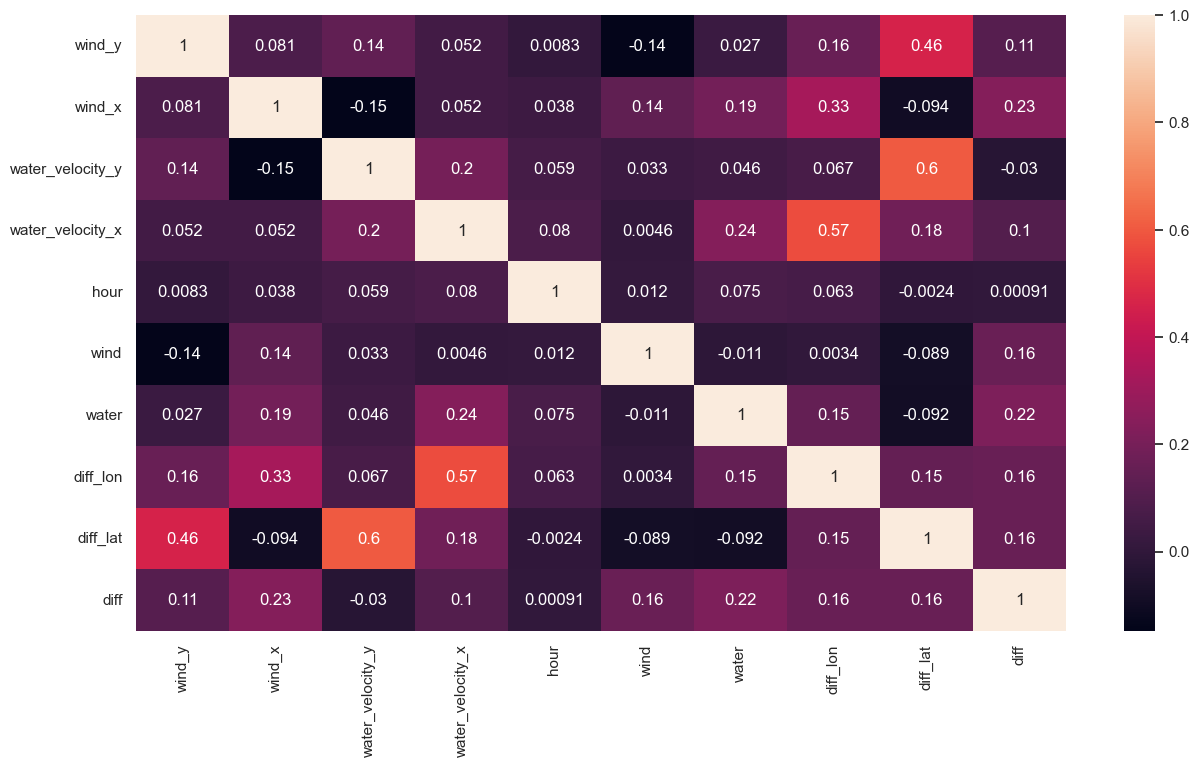

In [5]:
sns.set_palette("pastel")
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(train_df.corr(), annot = True)

array([[<Axes: title={'center': 'wind_y'}>,
        <Axes: title={'center': 'wind_x'}>,
        <Axes: title={'center': 'water_velocity_y'}>],
       [<Axes: title={'center': 'water_velocity_x'}>,
        <Axes: title={'center': 'hour'}>,
        <Axes: title={'center': 'wind'}>],
       [<Axes: title={'center': 'water'}>,
        <Axes: title={'center': 'diff_lon'}>,
        <Axes: title={'center': 'diff_lat'}>],
       [<Axes: title={'center': 'diff'}>, <Axes: >, <Axes: >]],
      dtype=object)

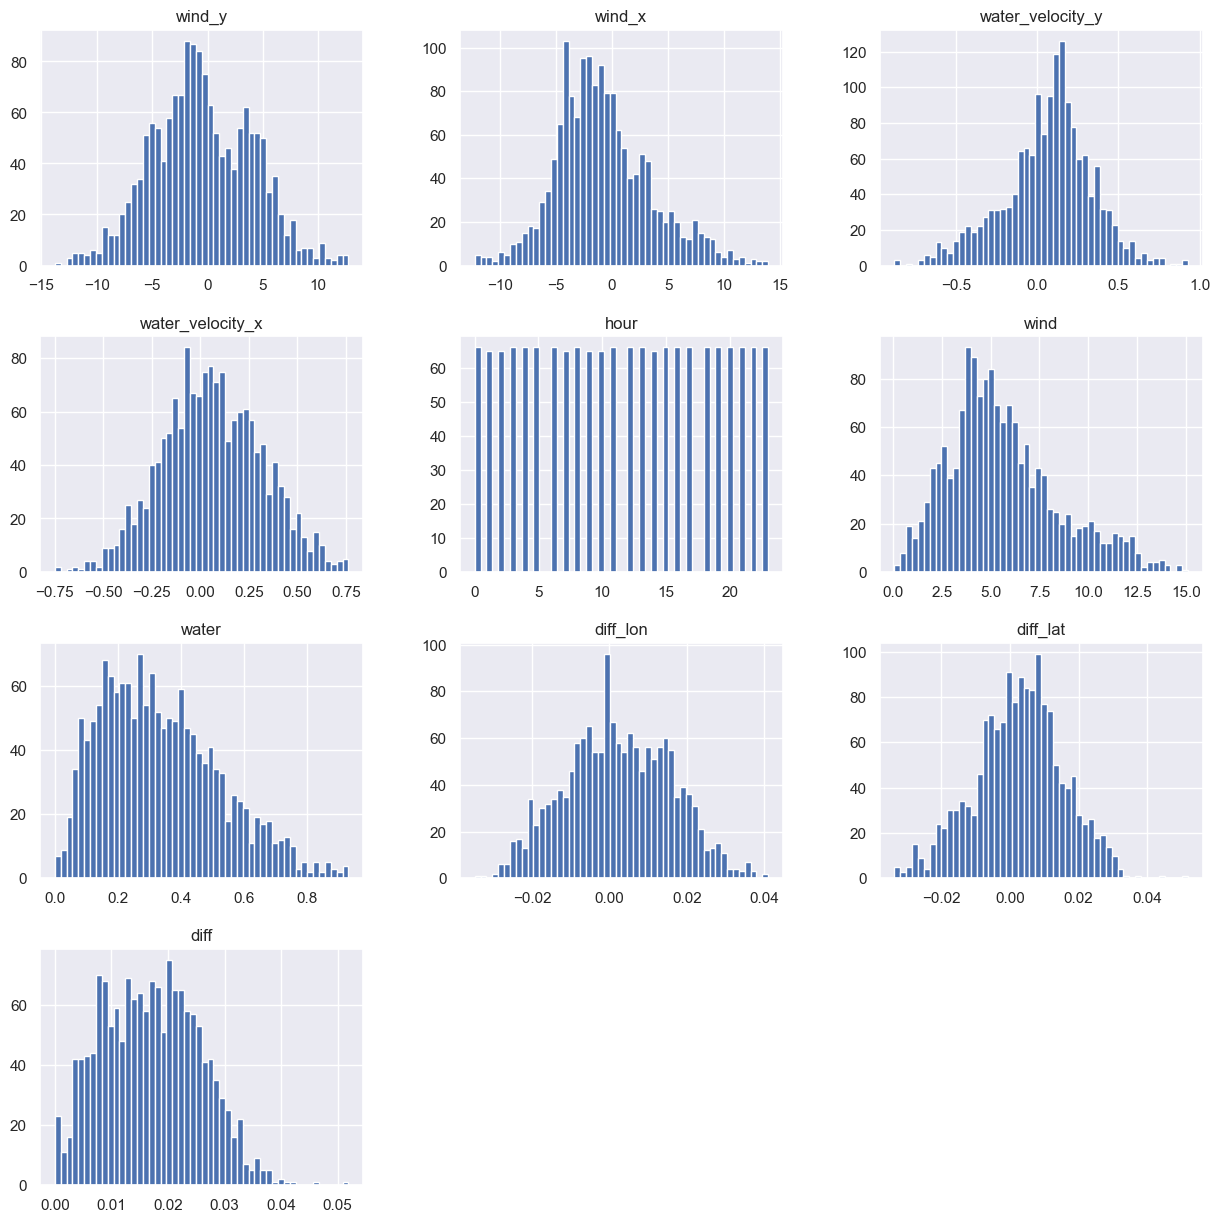

In [6]:
train_df.hist(bins = 50, figsize = (15,15))

<Axes: xlabel='hour', ylabel='diff'>

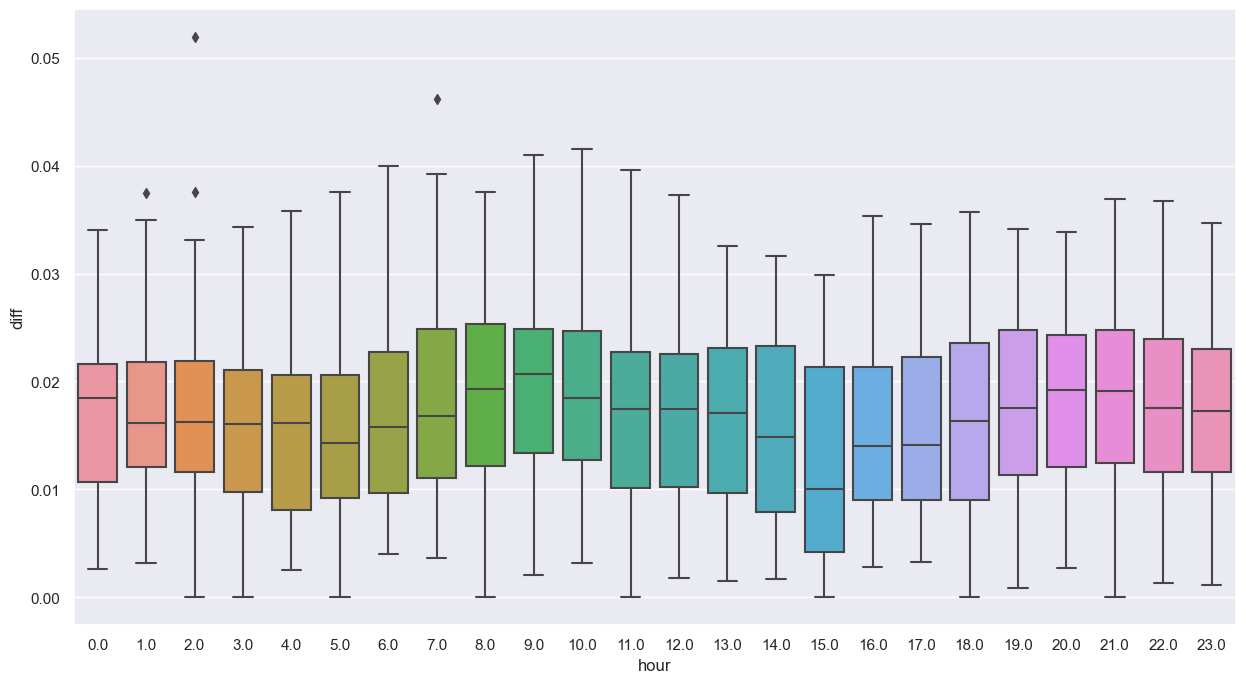

In [7]:
sns.boxplot(x='hour', y = 'diff', data = train_df)

Text(0, 0.5, 'count')

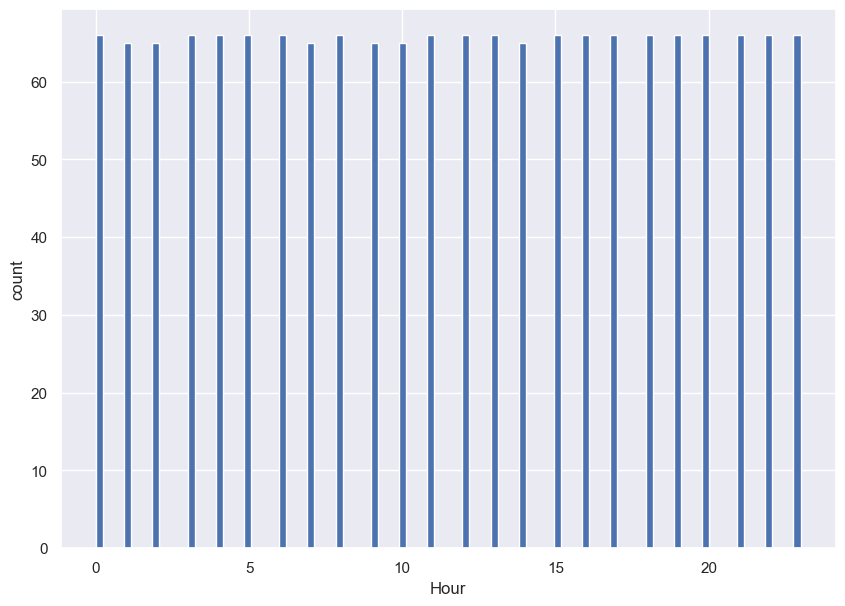

In [8]:
plt.figure(figsize=(10,7))
plt.hist(train_df['hour'], bins=100)
plt.xlabel('Hour')
plt.ylabel('count')

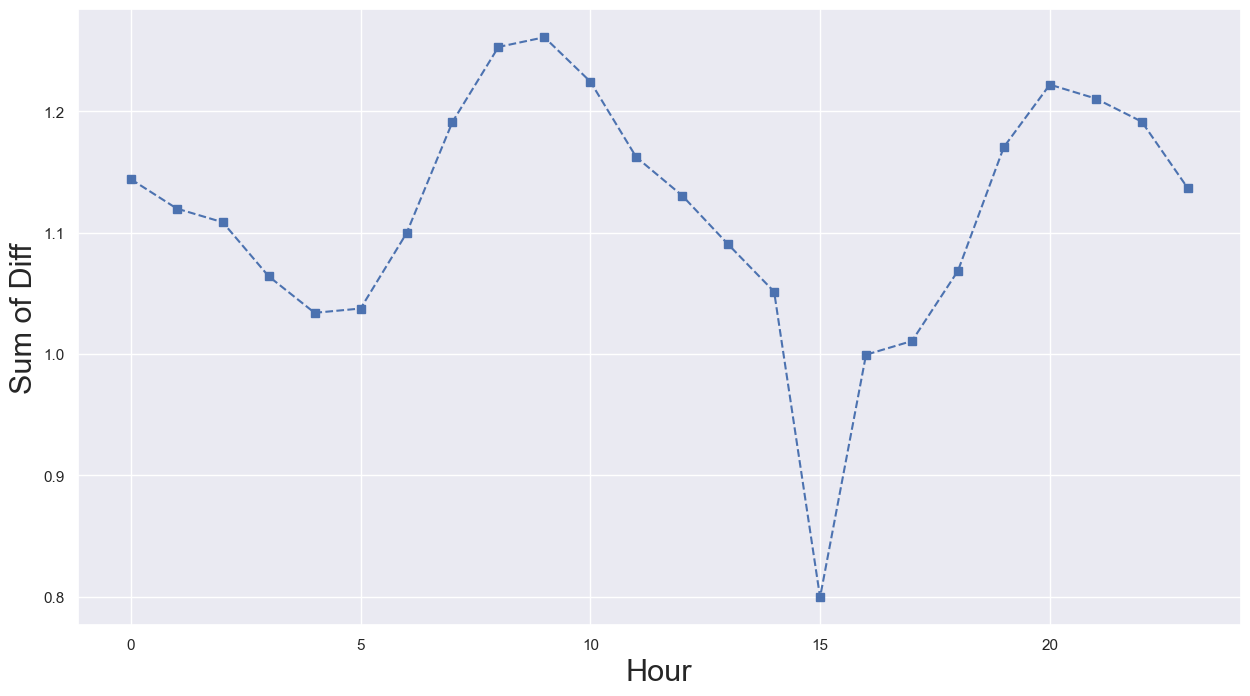

In [9]:
train_df_GroupByHour = train_df.groupby('hour').sum()
plt.xlabel('Hour',fontdict={'fontsize':22})
plt.ylabel('Sum of Diff',fontdict={'fontsize':22})
plt.plot(train_df_GroupByHour['diff'],'bs--')

# diff_sum_by_hour = df.groupby('hour')..sum()
# diff_sum_by_hour

In [10]:
# 모든 sample 합친 DataFrame의 basemodel Mae
y = concat_df[['obs_x1_lon', 'obs_x1_lat']]
basemodel_y = concat_df[['model_x2_lon', 'model_x2_lat']]
y = y.to_numpy()
basemodel_y = basemodel_y.to_numpy()
drift_mae(y,basemodel_y)

0.17666708079847943

In [20]:
# Basemodel의 평균 Mae와 NCLS
mae_sum = 0
NCLS_sum = 0
n = len(dataset)

for i in range(n):
    y = dataset[i][['obs_x1_lon', 'obs_x1_lat']]
    basemodel_y = dataset[i][['model_x2_lon', 'model_x2_lat']]
    y = y.to_numpy()
    basemodel_y = basemodel_y.to_numpy()    
    mae_sum += n2_mae(y,basemodel_y)
print('BaseModel의 평균 Mae : ', mae_sum/n)

for i in range(n):
    y = dataset[i][['obs_x1_lon', 'obs_x1_lat']]
    basemodel_y = dataset[i][['model_x2_lon', 'model_x2_lat']]
    y = y.to_numpy()
    basemodel_y = basemodel_y.to_numpy()    
    NCLS_sum += NCLS_score(y, basemodel_y)
print('Basemodel의 평균 NCLS : ', NCLS_sum/n)

BaseModel의 평균 Mae :  0.1764892833067855
Basemodel의 평균 NCLS :  0.5313479738992674


In [13]:
# Basemodel의 평균 Mae와 NCLS
mae_sum = 0
NCLS_sum = 0
n = len(dataset)

for i in range(n):
    y = dataset[i][['obs_x1_lon', 'obs_x1_lat']]
    basemodel_y = dataset[i][['model_x2_lon', 'model_x2_lat']]
    y = y.to_numpy()
    basemodel_y = basemodel_y.to_numpy()    
    mae_sum += paper_mae(y,basemodel_y)
print('BaseModel의 평균 Mae : ', mae_sum/n)

for i in range(n):
    y = dataset[i][['obs_x1_lon', 'obs_x1_lat']]
    basemodel_y = dataset[i][['model_x2_lon', 'model_x2_lat']]
    y = y.to_numpy()
    basemodel_y = basemodel_y.to_numpy()    
    NCLS_sum += NCLS_score(y, basemodel_y)
print('Basemodel의 평균 NCLS : ', NCLS_sum/n)

BaseModel의 평균 Mae :  0.352978566613571
Basemodel의 평균 NCLS :  0.5313479738992674


In [22]:
# 시작점에서 움직이지 않을때 Mae와 NCLS
mae_sum = 0 
NCLS_sum = 0
n = len(dataset)
for i in range(n):
    # 실제경로
    y = dataset[i][['obs_x1_lon', 'obs_x1_lat']]
    y = y.to_numpy()
    # 시작점에서 움직이지 않는 Drift
    df = dataset[i]
    df['start_lon'] = df['obs_x1_lon'][0]
    df['start_lat'] = df['obs_x1_lat'][0]
    pred_y = df[['start_lon','start_lat']]
    pred_y = pred_y.to_numpy()
    mae_sum += drift_mae(y,pred_y)
    print
print('시작점에서 고정된 Dirft의 평균 Mae : ', mae_sum/n)

for i in range(n):
    # 실제경로
    y = dataset[i][['obs_x1_lon', 'obs_x1_lat']]
    y = y.to_numpy()
    # 시작점에서 움직이지 않는 Drift
    df = dataset[i]
    df['start_lon'] = df['obs_x1_lon'][0]
    df['start_lat'] = df['obs_x1_lat'][0]
    pred_y = df[['start_lon','start_lat']]
    pred_y = pred_y.to_numpy()  
    NCLS_sum += NCLS_score(y, pred_y)
    
print('시작점에서 고정된 Dirft의 평균 NCLS : ', NCLS_sum/n)

시작점에서 고정된 Dirft의 평균 Mae :  0.2316552960909391
시작점에서 고정된 Dirft의 평균 NCLS :  0.391393855549236


--------------------- Model  0  ----------------------
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 2)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
93/93 [==============================] - 0s 1ms/step - loss: 0.2962 - mae: 0.4240
Epoch 2/70
93/93 [==============================] - 0s 1ms/step - loss: 0.1979 - mae: 0.3472
Epoch 3/70
93/93 [==============================] - 0s 1ms/step - loss: 0.1319 - mae: 0.2824
Epoch 4/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0870 - mae: 0.2276
Epoch 5/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0566 - mae: 0.1817
Epoch 6/70
93/93 [==============================] - 0s 1ms/step -

93/93 [==============================] - 0s 1ms/step - loss: 0.1066 - mae: 0.2487
Epoch 9/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0785 - mae: 0.2126
Epoch 10/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0570 - mae: 0.1805
Epoch 11/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0408 - mae: 0.1522
Epoch 12/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0288 - mae: 0.1274
Epoch 13/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0200 - mae: 0.1053
Epoch 14/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0136 - mae: 0.0862
Epoch 15/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0092 - mae: 0.0701
Epoch 16/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0061 - mae: 0.0566
Epoch 17/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0040 - mae: 0.0454
Epoch 18/70
93/93 [==============================] - 0s 1ms/step - loss: 

93/93 [==============================] - 0s 1ms/step - loss: 2.7771e-04 - mae: 0.0128
Epoch 23/70
93/93 [==============================] - 0s 1ms/step - loss: 1.9505e-04 - mae: 0.0109
Epoch 24/70
93/93 [==============================] - 0s 1ms/step - loss: 1.4819e-04 - mae: 0.0096
Epoch 25/70
93/93 [==============================] - 0s 1ms/step - loss: 1.2205e-04 - mae: 0.0087
Epoch 26/70
93/93 [==============================] - 0s 1ms/step - loss: 1.0816e-04 - mae: 0.0081
Epoch 27/70
93/93 [==============================] - 0s 1ms/step - loss: 1.0107e-04 - mae: 0.0078
Epoch 28/70
93/93 [==============================] - 0s 1ms/step - loss: 9.7438e-05 - mae: 0.0076
Epoch 29/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5817e-05 - mae: 0.0075
Epoch 30/70
93/93 [==============================] - 0s 1ms/step - loss: 9.4935e-05 - mae: 0.0075
Epoch 31/70
93/93 [==============================] - 0s 1ms/step - loss: 9.4599e-05 - mae: 0.0075
Epoch 32/70
93/93 [=============

93/93 [==============================] - 0s 1ms/step - loss: 8.4409e-05 - mae: 0.0071
Epoch 37/70
93/93 [==============================] - 0s 1ms/step - loss: 8.4359e-05 - mae: 0.0071
Epoch 38/70
93/93 [==============================] - 0s 1ms/step - loss: 8.4355e-05 - mae: 0.0071
Epoch 39/70
93/93 [==============================] - 0s 1ms/step - loss: 8.4251e-05 - mae: 0.0071
Epoch 40/70
93/93 [==============================] - 0s 1ms/step - loss: 8.4277e-05 - mae: 0.0071
Epoch 41/70
93/93 [==============================] - 0s 1ms/step - loss: 8.4324e-05 - mae: 0.0071
Epoch 42/70
93/93 [==============================] - 0s 1ms/step - loss: 8.4325e-05 - mae: 0.0071
Epoch 43/70
93/93 [==============================] - 0s 1ms/step - loss: 8.4286e-05 - mae: 0.0071
Epoch 44/70
93/93 [==============================] - 0s 1ms/step - loss: 8.4418e-05 - mae: 0.0071
Epoch 45/70
93/93 [==============================] - 0s 1ms/step - loss: 8.4331e-05 - mae: 0.0071
Epoch 46/70
93/93 [=============

93/93 [==============================] - 0s 2ms/step - loss: 9.1899e-05 - mae: 0.0074
Epoch 50/70
93/93 [==============================] - 0s 1ms/step - loss: 9.1979e-05 - mae: 0.0074
Epoch 51/70
93/93 [==============================] - 0s 1ms/step - loss: 9.2132e-05 - mae: 0.0074
Epoch 52/70
93/93 [==============================] - 0s 1ms/step - loss: 9.2061e-05 - mae: 0.0074
Epoch 53/70
93/93 [==============================] - 0s 1ms/step - loss: 9.2353e-05 - mae: 0.0074
Epoch 54/70
93/93 [==============================] - 0s 1ms/step - loss: 9.2293e-05 - mae: 0.0074
Epoch 55/70
93/93 [==============================] - 0s 1ms/step - loss: 9.1878e-05 - mae: 0.0074
Epoch 56/70
93/93 [==============================] - 0s 1ms/step - loss: 9.1945e-05 - mae: 0.0074
Epoch 57/70
93/93 [==============================] - 0s 1ms/step - loss: 9.2146e-05 - mae: 0.0074
Epoch 58/70
93/93 [==============================] - 0s 1ms/step - loss: 9.2193e-05 - mae: 0.0074
Epoch 59/70
93/93 [=============

93/93 [==============================] - 0s 1ms/step - loss: 9.5385e-05 - mae: 0.0075
Epoch 64/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5443e-05 - mae: 0.0075
Epoch 65/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5364e-05 - mae: 0.0075
Epoch 66/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5838e-05 - mae: 0.0075
Epoch 67/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5585e-05 - mae: 0.0075
Epoch 68/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5567e-05 - mae: 0.0075
Epoch 69/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5753e-05 - mae: 0.0075
Epoch 70/70
3/3 [==============================] - 0s 2ms/step
Model 10  MAE :  0.14471112384637635
Model 10  NCLS :  0.634108665141365
--------------------- Model  11  ----------------------
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape    

Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
93/93 [==============================] - 0s 1ms/step - loss: 0.8303 - mae: 0.7034
Epoch 2/70
93/93 [==============================] - 0s 1ms/step - loss: 0.6354 - mae: 0.6161
Epoch 3/70
93/93 [==============================] - 0s 1ms/step - loss: 0.4823 - mae: 0.5360
Epoch 4/70
93/93 [==============================] - 0s 1ms/step - loss: 0.3617 - mae: 0.4633
Epoch 5/70
93/93 [==============================] - 0s 1ms/step - loss: 0.2680 - mae: 0.3983
Epoch 6/70
93/93 [==============================] - 0s 1ms/step - loss: 0.1957 - mae: 0.3390
Epoch 7/70
93/93 [==============================] - 0s 1ms/step - loss: 0.1407 - mae: 0.2863
Epoch 8/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0997 - mae: 0.2399
Epoch 9/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0695 - mae: 0.1992
Epoch 10/70
93/93 [================

93/93 [==============================] - 0s 1ms/step - loss: 0.0307 - mae: 0.1378
Epoch 14/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0205 - mae: 0.1126
Epoch 15/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0134 - mae: 0.0909
Epoch 16/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0086 - mae: 0.0725
Epoch 17/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0054 - mae: 0.0572
Epoch 18/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0033 - mae: 0.0447
Epoch 19/70
93/93 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0347
Epoch 20/70
93/93 [==============================] - 0s 975us/step - loss: 0.0012 - mae: 0.0268
Epoch 21/70
93/93 [==============================] - 0s 997us/step - loss: 7.0111e-04 - mae: 0.0206
Epoch 22/70
93/93 [==============================] - 0s 915us/step - loss: 4.2361e-04 - mae: 0.0161
Epoch 23/70
93/93 [==============================] - 0s 97

93/93 [==============================] - 0s 1ms/step - loss: 1.5003e-04 - mae: 0.0095
Epoch 26/70
93/93 [==============================] - 0s 1ms/step - loss: 1.2594e-04 - mae: 0.0088
Epoch 27/70
93/93 [==============================] - 0s 950us/step - loss: 1.1193e-04 - mae: 0.0083
Epoch 28/70
93/93 [==============================] - 0s 929us/step - loss: 1.0412e-04 - mae: 0.0080
Epoch 29/70
93/93 [==============================] - 0s 1ms/step - loss: 9.9835e-05 - mae: 0.0078
Epoch 30/70
93/93 [==============================] - 0s 1ms/step - loss: 9.7420e-05 - mae: 0.0077
Epoch 31/70
93/93 [==============================] - 0s 1ms/step - loss: 9.6274e-05 - mae: 0.0076
Epoch 32/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5792e-05 - mae: 0.0076
Epoch 33/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5558e-05 - mae: 0.0075
Epoch 34/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5523e-05 - mae: 0.0075
Epoch 35/70
93/93 [=========

93/93 [==============================] - 0s 1ms/step - loss: 9.5438e-05 - mae: 0.0075
Epoch 38/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5640e-05 - mae: 0.0075
Epoch 39/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5306e-05 - mae: 0.0075
Epoch 40/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5442e-05 - mae: 0.0075
Epoch 41/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5438e-05 - mae: 0.0075
Epoch 42/70
93/93 [==============================] - 0s 997us/step - loss: 9.5560e-05 - mae: 0.0075
Epoch 43/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5300e-05 - mae: 0.0075
Epoch 44/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5655e-05 - mae: 0.0075
Epoch 45/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5666e-05 - mae: 0.0075
Epoch 46/70
93/93 [==============================] - 0s 963us/step - loss: 9.5674e-05 - mae: 0.0075
Epoch 47/70
93/93 [=========

93/93 [==============================] - 0s 1ms/step - loss: 9.5330e-05 - mae: 0.0075
Epoch 50/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5291e-05 - mae: 0.0075
Epoch 51/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5343e-05 - mae: 0.0075
Epoch 52/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5134e-05 - mae: 0.0075
Epoch 53/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5260e-05 - mae: 0.0075
Epoch 54/70
93/93 [==============================] - 0s 1ms/step - loss: 9.5813e-05 - mae: 0.0075
Epoch 55/70
93/93 [==============================] - 0s 871us/step - loss: 9.5370e-05 - mae: 0.0075
Epoch 56/70
93/93 [==============================] - 0s 836us/step - loss: 9.5360e-05 - mae: 0.0075
Epoch 57/70
93/93 [==============================] - 0s 873us/step - loss: 9.5596e-05 - mae: 0.0075
Epoch 58/70
93/93 [==============================] - 0s 858us/step - loss: 9.5655e-05 - mae: 0.0075
Epoch 59/70
93/93 [=====

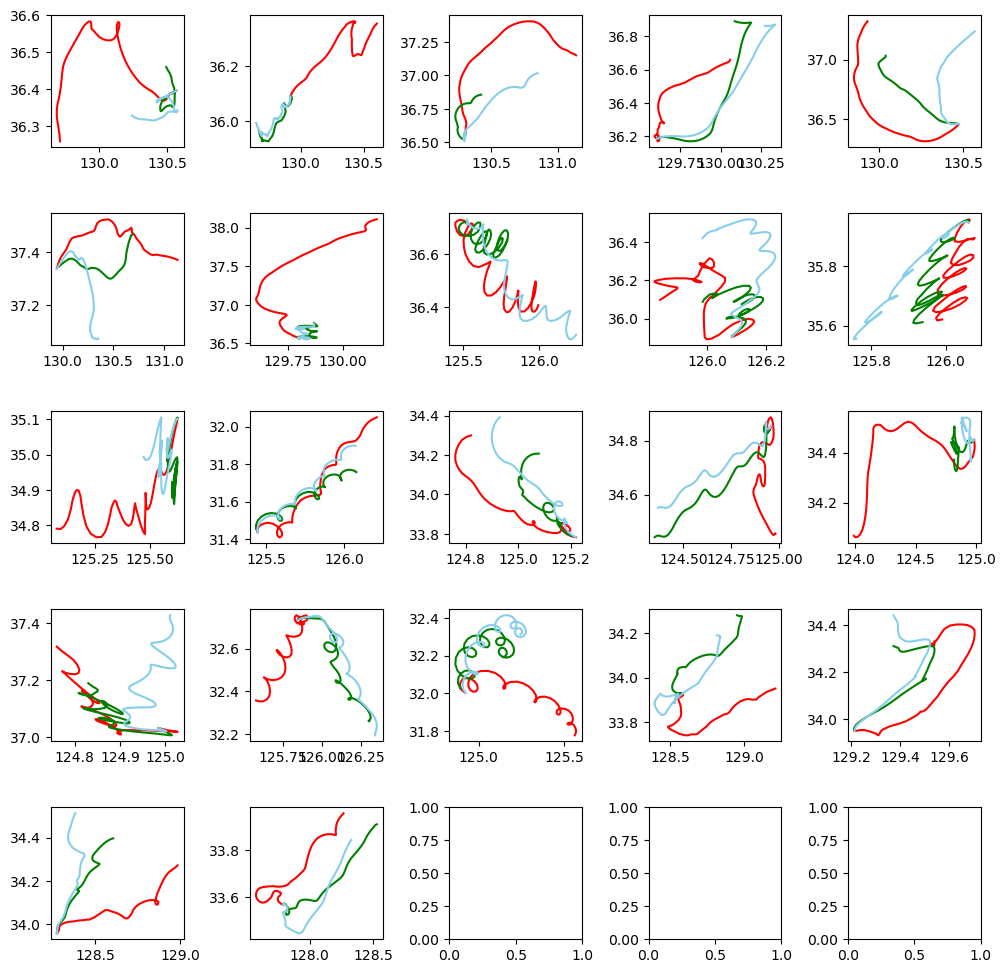

In [21]:
# Linear model 

f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
        
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    train_X, test_X = roburst_scaler(train_X, test_X)
    # 선형모델 생성
    linear = tf.keras.Sequential([
    Dense(units = 2, input_dim = 4)
    ])
    
    linear.summary()
    linear.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    linear.fit(train_X, train_y, epochs = 70, batch_size = 16)
    
    # model save
#     linear.save(str(i)+'linear_model.h5')

    # Predict
    y_pred = linear.predict(test_X)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [22]:
linear_mae_sum = 0
linear_NCLS_sum = 0
for i in range(len(dataset)):
    print('---------------- ',i+1,'model ----------------')
    linear_mae_sum += MAE_list[i]
    linear_NCLS_sum += NCLS_list[i]
    print(i+1,'model의 MAE : ',MAE_list[i])
    print(i+1,'model의 NCLS : ',NCLS_list[i])
    print('---------------------------------------------')
    print(' ')

# 라이브러리 Mae    
print ('평균 Mae : ', linear_mae_sum/len(dataset) )
print ('평균 NCLS : ', linear_NCLS_sum/len(dataset) )

----------------  1 model ----------------
1 model의 MAE :  0.2564138810374568
1 model의 NCLS :  0.33017043082224473
---------------------------------------------
 
----------------  2 model ----------------
2 model의 MAE :  0.4098839857292176
2 model의 NCLS :  0
---------------------------------------------
 
----------------  3 model ----------------
3 model의 MAE :  0.23921507313200577
3 model의 NCLS :  0.48644930491973504
---------------------------------------------
 
----------------  4 model ----------------
4 model의 MAE :  0.2663384956781123
4 model의 NCLS :  0
---------------------------------------------
 
----------------  5 model ----------------
5 model의 MAE :  0.24029826837209026
5 model의 NCLS :  0.43676574938177426
---------------------------------------------
 
----------------  6 model ----------------
6 model의 MAE :  0.25165855577165247
6 model의 NCLS :  0.43441445604954265
---------------------------------------------
 
----------------  7 model ----------------
7 model의 MAE

--------------------- Model  0  ----------------------
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 2)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
93/93 [==============================] - 0s 1ms/step - loss: 0.6196 - mae: 0.6370
Epoch 2/50
93/93 [==============================] - 0s 1ms/step - loss: 0.4500 - mae: 0.5409
Epoch 3/50
93/93 [==============================] - 0s 1ms/step - loss: 0.3258 - mae: 0.4576
Epoch 4/50
93/93 [==============================] - 0s 1ms/step - loss: 0.2342 - mae: 0.3854
Epoch 5/50
93/93 [==============================] - 0s 1ms/step - loss: 0.1672 - mae: 0.3242
Epoch 6/50
93/93 [==============================] - 0s 1ms/step -

93/93 [==============================] - 0s 1ms/step - loss: 8.7730e-05 - mae: 0.0072
Epoch 49/50
93/93 [==============================] - 0s 1ms/step - loss: 8.7913e-05 - mae: 0.0072
Epoch 50/50
3/3 [==============================] - 0s 1ms/step
Model 2  MAE :  0.17124358726465863
Model 2  NCLS :  0.6303776837875839
--------------------- Model  3  ----------------------
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 2)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
93/93 [==============================] - 0s 1ms/step - loss: 0.5531 - mae: 0.5737
Epoch 2/50
93/93 [==============================] - 0s 1ms/step - loss: 0.4086 - mae: 0.4935
Epoch 3/50
93/93 [=======

93/93 [==============================] - 0s 993us/step - loss: 9.1372e-05 - mae: 0.0074
Epoch 45/50
93/93 [==============================] - 0s 1ms/step - loss: 9.1705e-05 - mae: 0.0074
Epoch 46/50
93/93 [==============================] - 0s 1ms/step - loss: 9.1158e-05 - mae: 0.0074
Epoch 47/50
93/93 [==============================] - 0s 1ms/step - loss: 9.1236e-05 - mae: 0.0074
Epoch 48/50
93/93 [==============================] - 0s 1ms/step - loss: 9.1572e-05 - mae: 0.0074
Epoch 49/50
93/93 [==============================] - 0s 1ms/step - loss: 9.1418e-05 - mae: 0.0074
Epoch 50/50
3/3 [==============================] - 0s 1ms/step
Model 5  MAE :  0.19305246741817955
Model 5  NCLS :  0.5515666769904725
--------------------- Model  6  ----------------------
Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 2)                 14        
           

93/93 [==============================] - 0s 1ms/step - loss: 8.8044e-05 - mae: 0.0072
Epoch 42/50
93/93 [==============================] - 0s 1ms/step - loss: 8.8035e-05 - mae: 0.0072
Epoch 43/50
93/93 [==============================] - 0s 1ms/step - loss: 8.7880e-05 - mae: 0.0072
Epoch 44/50
93/93 [==============================] - 0s 1ms/step - loss: 8.8189e-05 - mae: 0.0073
Epoch 45/50
93/93 [==============================] - 0s 1ms/step - loss: 8.8048e-05 - mae: 0.0072
Epoch 46/50
93/93 [==============================] - 0s 1ms/step - loss: 8.8185e-05 - mae: 0.0072
Epoch 47/50
93/93 [==============================] - 0s 1ms/step - loss: 8.8151e-05 - mae: 0.0073
Epoch 48/50
93/93 [==============================] - 0s 1ms/step - loss: 8.8118e-05 - mae: 0.0072
Epoch 49/50
93/93 [==============================] - 0s 1ms/step - loss: 8.8225e-05 - mae: 0.0072
Epoch 50/50
3/3 [==============================] - 0s 1ms/step
Model 8  MAE :  0.08845823514149699
Model 8  NCLS :  0.812246769013

93/93 [==============================] - 0s 1ms/step - loss: 9.2280e-05 - mae: 0.0074
Epoch 39/50
93/93 [==============================] - 0s 1ms/step - loss: 9.2095e-05 - mae: 0.0074
Epoch 40/50
93/93 [==============================] - 0s 2ms/step - loss: 9.2189e-05 - mae: 0.0074
Epoch 41/50
93/93 [==============================] - 0s 2ms/step - loss: 9.2404e-05 - mae: 0.0074
Epoch 42/50
93/93 [==============================] - 0s 2ms/step - loss: 9.2343e-05 - mae: 0.0074
Epoch 43/50
93/93 [==============================] - 0s 1ms/step - loss: 9.2211e-05 - mae: 0.0074
Epoch 44/50
93/93 [==============================] - 0s 1ms/step - loss: 9.2447e-05 - mae: 0.0074
Epoch 45/50
93/93 [==============================] - 0s 1ms/step - loss: 9.2506e-05 - mae: 0.0074
Epoch 46/50
93/93 [==============================] - 0s 1ms/step - loss: 9.2525e-05 - mae: 0.0074
Epoch 47/50
93/93 [==============================] - 0s 1ms/step - loss: 9.2490e-05 - mae: 0.0074
Epoch 48/50
93/93 [=============

93/93 [==============================] - 0s 1ms/step - loss: 0.0281 - mae: 0.1055
Epoch 9/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0183 - mae: 0.0838
Epoch 10/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0116 - mae: 0.0662
Epoch 11/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0072 - mae: 0.0523
Epoch 12/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0044 - mae: 0.0412
Epoch 13/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0026 - mae: 0.0323
Epoch 14/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0015 - mae: 0.0254
Epoch 15/50
93/93 [==============================] - 0s 1ms/step - loss: 8.8523e-04 - mae: 0.0201
Epoch 16/50
93/93 [==============================] - 0s 1ms/step - loss: 5.1568e-04 - mae: 0.0161
Epoch 17/50
93/93 [==============================] - 0s 1ms/step - loss: 3.1166e-04 - mae: 0.0131
Epoch 18/50
93/93 [==============================] - 0s 1ms/s

93/93 [==============================] - 0s 1ms/step - loss: 0.2123 - mae: 0.3559
Epoch 5/50
93/93 [==============================] - 0s 1ms/step - loss: 0.1514 - mae: 0.2998
Epoch 6/50
93/93 [==============================] - 0s 1ms/step - loss: 0.1064 - mae: 0.2501
Epoch 7/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0735 - mae: 0.2060
Epoch 8/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0500 - mae: 0.1686
Epoch 9/50
93/93 [==============================] - 0s 980us/step - loss: 0.0336 - mae: 0.1363
Epoch 10/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0222 - mae: 0.1097
Epoch 11/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0145 - mae: 0.0874
Epoch 12/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0094 - mae: 0.0691
Epoch 13/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0060 - mae: 0.0546
Epoch 14/50
93/93 [==============================] - 0s 1ms/step - loss: 0.

Epoch 1/50
93/93 [==============================] - 0s 1ms/step - loss: 0.7035 - mae: 0.6620
Epoch 2/50
93/93 [==============================] - 0s 1ms/step - loss: 0.5100 - mae: 0.5548
Epoch 3/50
93/93 [==============================] - 0s 1ms/step - loss: 0.3710 - mae: 0.4681
Epoch 4/50
93/93 [==============================] - 0s 940us/step - loss: 0.2705 - mae: 0.3983
Epoch 5/50
93/93 [==============================] - 0s 963us/step - loss: 0.1971 - mae: 0.3410
Epoch 6/50
93/93 [==============================] - 0s 866us/step - loss: 0.1438 - mae: 0.2923
Epoch 7/50
93/93 [==============================] - 0s 820us/step - loss: 0.1048 - mae: 0.2505
Epoch 8/50
93/93 [==============================] - 0s 826us/step - loss: 0.0762 - mae: 0.2153
Epoch 9/50
93/93 [==============================] - 0s 931us/step - loss: 0.0552 - mae: 0.1852
Epoch 10/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0400 - mae: 0.1588
Epoch 11/50
93/93 [==============================] - 0s 1

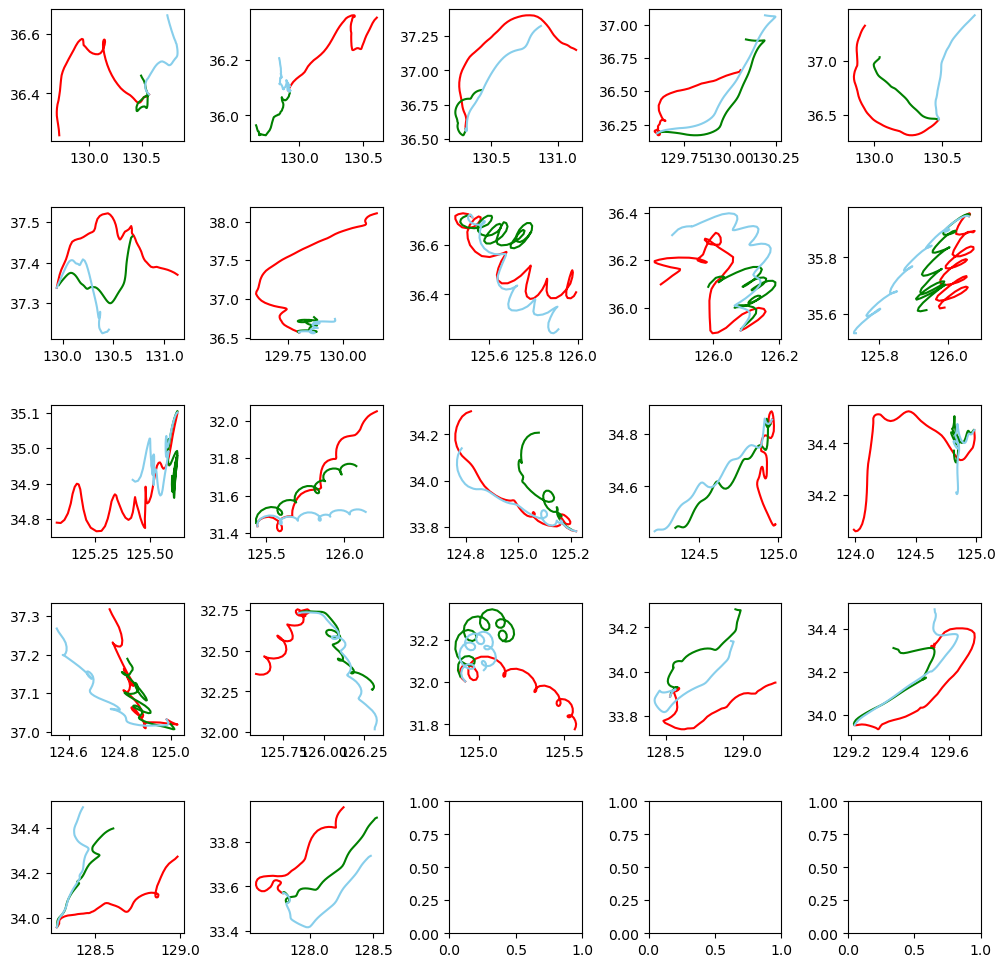

In [25]:
# Linear model (특성 6)

f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','start_lon','start_lat']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','start_lon','start_lat']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
        
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','start_lon','start_lat']]
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    train_X, test_X = roburst_scaler(train_X, test_X)
    
    # 선형모델 생성
    linear = tf.keras.Sequential([
    Dense(units = 2, input_dim = 6)
    ])
    
    linear.summary()
    linear.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    linear.fit(train_X, train_y, epochs = 50, batch_size = 16)
    
    # model save
#     linear.save(str(i)+'linear_model.h5')

    # Predict
    y_pred = linear.predict(test_X)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [26]:
linear_mae_sum = 0
linear_NCLS_sum = 0
for i in range(len(dataset)):
    print('---------------- ',i+1,'model ----------------')
    linear_mae_sum += MAE_list[i]
    linear_NCLS_sum += NCLS_list[i]
    print(i+1,'model의 MAE : ',MAE_list[i])
    print(i+1,'model의 NCLS : ',NCLS_list[i])
    print('---------------------------------------------')
    print(' ')

# 라이브러리 Mae    
print ('평균 Mae : ', linear_mae_sum/len(dataset) )
print ('평균 NCLS : ', linear_NCLS_sum/len(dataset) )

----------------  1 model ----------------
1 model의 MAE :  0.3569280133111048
1 model의 NCLS :  0
---------------------------------------------
 
----------------  2 model ----------------
2 model의 MAE :  0.3057592400424882
2 model의 NCLS :  0.16401654969164114
---------------------------------------------
 
----------------  3 model ----------------
3 model의 MAE :  0.17124358726465863
3 model의 NCLS :  0.6303776837875839
---------------------------------------------
 
----------------  4 model ----------------
4 model의 MAE :  0.2963940744961231
4 model의 NCLS :  0
---------------------------------------------
 
----------------  5 model ----------------
5 model의 MAE :  0.33959265251538623
5 model의 NCLS :  0.24680309480942442
---------------------------------------------
 
----------------  6 model ----------------
6 model의 MAE :  0.19305246741817955
6 model의 NCLS :  0.5515666769904725
---------------------------------------------
 
----------------  7 model ----------------
7 model의 MAE :

--------------------- Model  0  ----------------------
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 1s 768us/step - loss: 22.1278 - mae: 3.9133
Epoch 2/30
185/185 [==============================] - 0s 778us/step - loss: 15.2056 - mae: 3.2448
Epoch 3/30
185/185 [==============================] - 0s 785us/step - loss: 10.0578 - mae: 2.6369
Epoch 4/30
185/185 [==============================] - 0s 823us/step - loss: 6.3495 - mae: 2.0943
Epoch 5/30
185/185 [==============================] - 0s 831us/step - loss: 3.8844 - mae: 1.6377
Epoch 6/30
185/185 [========================

185/185 [==============================] - 0s 930us/step - loss: 4.5583e-04 - mae: 0.0168
Epoch 12/30
185/185 [==============================] - 0s 910us/step - loss: 2.0167e-04 - mae: 0.0113
Epoch 13/30
185/185 [==============================] - 0s 940us/step - loss: 1.4862e-04 - mae: 0.0099
Epoch 14/30
185/185 [==============================] - 0s 896us/step - loss: 1.3951e-04 - mae: 0.0097
Epoch 15/30
185/185 [==============================] - 0s 910us/step - loss: 1.3805e-04 - mae: 0.0097
Epoch 16/30
185/185 [==============================] - 0s 903us/step - loss: 1.3795e-04 - mae: 0.0097
Epoch 17/30
185/185 [==============================] - 0s 923us/step - loss: 1.3797e-04 - mae: 0.0097
Epoch 18/30
185/185 [==============================] - 0s 906us/step - loss: 1.3790e-04 - mae: 0.0097
Epoch 19/30
185/185 [==============================] - 0s 911us/step - loss: 1.3795e-04 - mae: 0.0097
Epoch 20/30
185/185 [==============================] - 0s 899us/step - loss: 1.3798e-04 - mae:

185/185 [==============================] - 0s 879us/step - loss: 1.3813e-04 - mae: 0.0097
Epoch 20/30
185/185 [==============================] - 0s 870us/step - loss: 1.3799e-04 - mae: 0.0097
Epoch 21/30
185/185 [==============================] - 0s 900us/step - loss: 1.3803e-04 - mae: 0.0097
Epoch 22/30
185/185 [==============================] - 0s 920us/step - loss: 1.3802e-04 - mae: 0.0097
Epoch 23/30
185/185 [==============================] - 0s 898us/step - loss: 1.3804e-04 - mae: 0.0097
Epoch 24/30
185/185 [==============================] - 0s 943us/step - loss: 1.3801e-04 - mae: 0.0097
Epoch 25/30
185/185 [==============================] - 0s 1ms/step - loss: 1.3802e-04 - mae: 0.0097
Epoch 26/30
185/185 [==============================] - 0s 964us/step - loss: 1.3806e-04 - mae: 0.0097
Epoch 27/30
185/185 [==============================] - 0s 982us/step - loss: 1.3802e-04 - mae: 0.0097
Epoch 28/30
185/185 [==============================] - 0s 1ms/step - loss: 1.3810e-04 - mae: 0.0

                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 888us/step - loss: 23.8023 - mae: 4.0764
Epoch 2/30
185/185 [==============================] - 0s 931us/step - loss: 16.4847 - mae: 3.3895
Epoch 3/30
185/185 [==============================] - 0s 934us/step - loss: 11.0375 - mae: 2.7727
Epoch 4/30
185/185 [==============================] - 0s 973us/step - loss: 7.1099 - mae: 2.2208
Epoch 5/30
185/185 [==============================] - 0s 988us/step - loss: 4.3707 - mae: 1.7360
Epoch 6/30
185/185 [==============================] - 0s 973us/step - loss: 2.5682 - mae: 1.3307
Epoch 7/30
185/185 [==============================] - 0s 971us/step - loss: 1.4278 - mae: 0.9869
Epoch 8/30
185/185 [==============================] - 0s 986us/step - loss: 0.7489 - mae: 0.7127
Epoch 9/30
185/185 [=========

185/185 [==============================] - 0s 1ms/step - loss: 1.4154e-04 - mae: 0.0098
Epoch 17/30
185/185 [==============================] - 0s 1ms/step - loss: 1.4101e-04 - mae: 0.0098
Epoch 18/30
185/185 [==============================] - 0s 1ms/step - loss: 1.4292e-04 - mae: 0.0098
Epoch 19/30
185/185 [==============================] - 0s 1ms/step - loss: 1.4213e-04 - mae: 0.0098
Epoch 20/30
185/185 [==============================] - 0s 1ms/step - loss: 1.4214e-04 - mae: 0.0098
Epoch 21/30
185/185 [==============================] - 0s 999us/step - loss: 1.4277e-04 - mae: 0.0099
Epoch 22/30
185/185 [==============================] - 0s 1ms/step - loss: 1.4170e-04 - mae: 0.0099
Epoch 23/30
185/185 [==============================] - 0s 1ms/step - loss: 1.4201e-04 - mae: 0.0098
Epoch 24/30
185/185 [==============================] - 0s 1ms/step - loss: 1.4212e-04 - mae: 0.0098
Epoch 25/30
185/185 [==============================] - 0s 1ms/step - loss: 1.4391e-04 - mae: 0.0099
Epoch 26/3

 dense_98 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 754us/step - loss: 14.6427 - mae: 3.1696
Epoch 2/30
185/185 [==============================] - 0s 906us/step - loss: 9.2753 - mae: 2.5236
Epoch 3/30
185/185 [==============================] - 0s 1ms/step - loss: 5.5821 - mae: 1.9550
Epoch 4/30
185/185 [==============================] - 0s 998us/step - loss: 3.1581 - mae: 1.4698
Epoch 5/30
185/185 [==============================] - 0s 1ms/step - loss: 1.6575 - mae: 1.0627
Epoch 6/30
185/185 [==============================] - 0s 1ms/step - loss: 0.8069 - mae: 0.7388
Epoch 7/30
185/185 [==============================] - 0s 1ms/step - loss: 0.3600 - mae: 0.4925
Epoch 8/30
185/185 [==============================] - 0s 1ms/step - lo

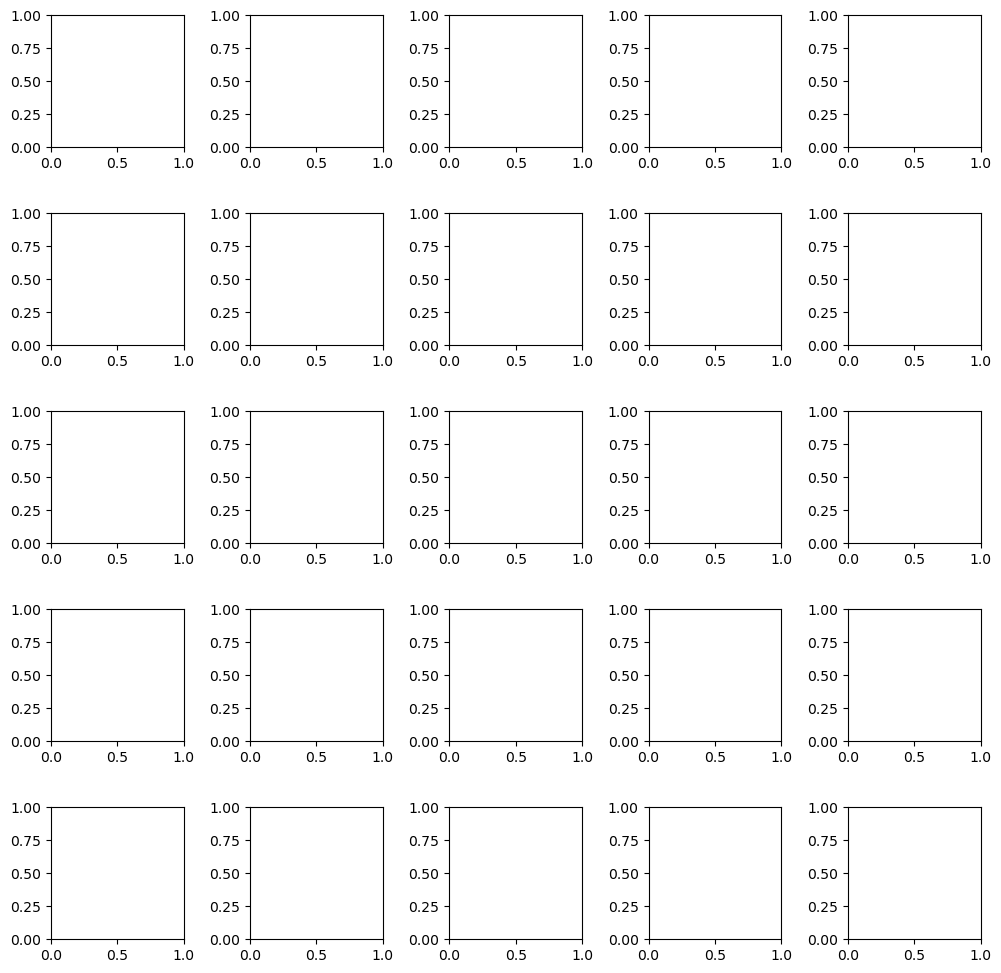

In [17]:
# Linear model & 이전데이터 추가 & diff_x 예측 & wind_x만 사용

f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['wind_x']]
    train_y = train[0][['diff_lon']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x']] 
        trina_yi = train[j][['diff_lon']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        trina_xi = only_train_dataset[k][['wind_x']] 
        trina_yi = only_train_dataset[k][['diff_lon']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
        
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x']]
    test_X = test_X[1:]
    test_y = test[['diff_lon']]
    test_y = test_y[1:].to_numpy()

    # 선형모델 생성
    linear = tf.keras.Sequential([
    Dense(units = 1, input_dim = 1)
    ])
    
    linear.summary()
    linear.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    linear.fit(train_X, train_y, epochs = 30, batch_size = 16)

    # Predict
    y_pred = linear.predict(test_X)

    # 실제 위치
    lon = dataset[i]['obs_x1_lon']
    lon = np.array(lon)
#     lat = dataset[i]['obs_x1_lat']
#     lat = np.array(lat)
    
    # 예측값 
    first_lon = lon[0]
#     first_lat = lat[0]
    lon_pred = np.zeros((y_pred.shape[0]+1,))
#     lat_pred = np.zeros((y_pred.shape[0]+1,))
    lon_pred[0] = first_lon 
#     lat_pred[0] = first_lat
    
    for t in range(1, lon_pred.shape[0]):
        lon_pred[t] = lon_pred[t-1] + y_pred[t-1][0]
#         lat_pred[i] = lat_pred[i-1] + y_pred[i-1][1]        
    
    # evaluation 
#     y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
#     pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(lon, lon_pred))
    MAE_list.append(drift_mae(lon, lon_pred))
    
    #NCLS
#     print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
#     NCLS_list.append(NCLS_score(y, pred))

In [18]:
linear_mae_sum = 0
for i in range(len(dataset)):
    print('---------------- ',i+1,'model ----------------')
    linear_mae_sum += MAE_list[i]
    print(i+1,'model의 MAE : ',MAE_list[i])
    print('---------------------------------------------')
    print(' ')

# 라이브러리 Mae    
print ('평균 Mae : ', linear_mae_sum/len(dataset) )

----------------  1 model ----------------
1 model의 MAE :  0.530376861135822
---------------------------------------------
 
----------------  2 model ----------------
2 model의 MAE :  0.39413976661092004
---------------------------------------------
 
----------------  3 model ----------------
3 model의 MAE :  0.11907513496304231
---------------------------------------------
 
----------------  4 model ----------------
4 model의 MAE :  0.0622397751007013
---------------------------------------------
 
----------------  5 model ----------------
5 model의 MAE :  0.5242767546047483
---------------------------------------------
 
----------------  6 model ----------------
6 model의 MAE :  0.3982435687614354
---------------------------------------------
 
----------------  7 model ----------------
7 model의 MAE :  0.15993428589637265
---------------------------------------------
 
----------------  8 model ----------------
8 model의 MAE :  0.31017193986048774
-------------------------------------

--------------------- Model  0  ----------------------
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 1s 1ms/step - loss: 0.0100 - mae: 0.0798
Epoch 2/30
185/185 [==============================] - 0s 788us/step - loss: 0.0045 - mae: 0.0533
Epoch 3/30
185/185 [==============================] - 0s 915us/step - loss: 0.0018 - mae: 0.0332
Epoch 4/30
185/185 [==============================] - 0s 850us/step - loss: 6.1386e-04 - mae: 0.0193
Epoch 5/30
185/185 [==============================] - 0s 813us/step - loss: 2.3037e-04 - mae: 0.0117
Epoch 6/30
185/185 [=====================

185/185 [==============================] - 0s 965us/step - loss: 2.1861e-04 - mae: 0.0122
Epoch 11/30
185/185 [==============================] - 0s 904us/step - loss: 1.4664e-04 - mae: 0.0098
Epoch 12/30
185/185 [==============================] - 0s 925us/step - loss: 1.2135e-04 - mae: 0.0088
Epoch 13/30
185/185 [==============================] - 0s 998us/step - loss: 1.1368e-04 - mae: 0.0084
Epoch 14/30
185/185 [==============================] - 0s 973us/step - loss: 1.1165e-04 - mae: 0.0083
Epoch 15/30
185/185 [==============================] - 0s 938us/step - loss: 1.1129e-04 - mae: 0.0083
Epoch 16/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1103e-04 - mae: 0.0082
Epoch 17/30
185/185 [==============================] - 0s 933us/step - loss: 1.1119e-04 - mae: 0.0083
Epoch 18/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1154e-04 - mae: 0.0083
Epoch 19/30
185/185 [==============================] - 0s 997us/step - loss: 1.1129e-04 - mae: 0.0

185/185 [==============================] - 0s 1ms/step - loss: 1.1025e-04 - mae: 0.0082
Epoch 25/30
185/185 [==============================] - 0s 1ms/step - loss: 1.0940e-04 - mae: 0.0082
Epoch 26/30
185/185 [==============================] - 0s 1ms/step - loss: 1.0965e-04 - mae: 0.0082
Epoch 27/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1012e-04 - mae: 0.0082
Epoch 28/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1016e-04 - mae: 0.0082
Epoch 29/30
185/185 [==============================] - 0s 1ms/step - loss: 1.0995e-04 - mae: 0.0082
Epoch 30/30
3/3 [==============================] - 0s 1ms/step
Model 8  MAE :  0.17077185390159816
--------------------- Model  9  ----------------------
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 1)                 2         
                                     

 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 867us/step - loss: 0.0038 - mae: 0.0495
Epoch 2/30
185/185 [==============================] - 0s 870us/step - loss: 0.0011 - mae: 0.0264
Epoch 3/30
185/185 [==============================] - 0s 1ms/step - loss: 2.7805e-04 - mae: 0.0136
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 1.3034e-04 - mae: 0.0091
Epoch 5/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1264e-04 - mae: 0.0084
Epoch 6/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1144e-04 - mae: 0.0083
Epoch 7/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1113e-04 -

Epoch 14/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1196e-04 - mae: 0.0082
Epoch 15/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1134e-04 - mae: 0.0082
Epoch 16/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1157e-04 - mae: 0.0083
Epoch 17/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1161e-04 - mae: 0.0082
Epoch 18/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1159e-04 - mae: 0.0083
Epoch 19/30
185/185 [==============================] - 0s 987us/step - loss: 1.1142e-04 - mae: 0.0083
Epoch 20/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1171e-04 - mae: 0.0083
Epoch 21/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1161e-04 - mae: 0.0083
Epoch 22/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1157e-04 - mae: 0.0083
Epoch 23/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1202e-04 - mae: 0.008

3/3 [==============================] - 0s 1ms/step
Model 19  MAE :  0.22953924650960308
--------------------- Model  20  ----------------------
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 1ms/step - loss: 0.1044 - mae: 0.2582
Epoch 2/30
185/185 [==============================] - 0s 875us/step - loss: 0.0806 - mae: 0.2270
Epoch 3/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0618 - mae: 0.1987
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0464 - mae: 0.1722
Epoch 5/30
185/185 [==============================] - 0s 1ms/

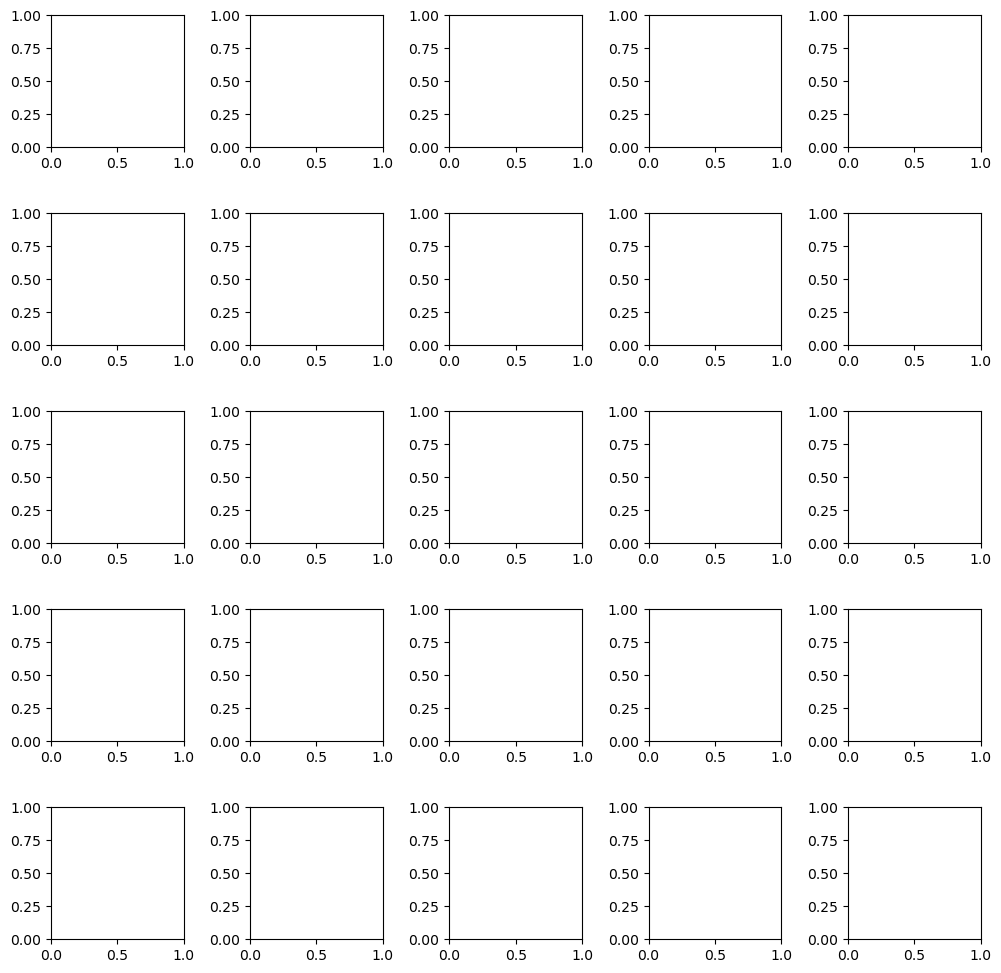

In [11]:
# Linear model & 이전데이터 추가 & diff_x 예측 & water_velocity_x만 사용

f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['water_velocity_x']]
    train_y = train[0][['diff_lon']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['water_velocity_x']] 
        trina_yi = train[j][['diff_lon']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        trina_xi = only_train_dataset[k][['water_velocity_x']] 
        trina_yi = only_train_dataset[k][['diff_lon']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
        
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['water_velocity_x']]
    test_X = test_X[1:]
    test_y = test[['diff_lon']]
    test_y = test_y[1:].to_numpy()

    # 선형모델 생성
    linear = tf.keras.Sequential([
    Dense(units = 1, input_dim = 1)
    ])
    
    linear.summary()
    linear.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    linear.fit(train_X, train_y, epochs = 30, batch_size = 16)

    # Predict
    y_pred = linear.predict(test_X)

    # 실제 위치
    lon = dataset[i]['obs_x1_lon']
    lon = np.array(lon)
#     lat = dataset[i]['obs_x1_lat']
#     lat = np.array(lat)
    
    # 예측값 
    first_lon = lon[0]
#     first_lat = lat[0]
    lon_pred = np.zeros((y_pred.shape[0]+1,))
#     lat_pred = np.zeros((y_pred.shape[0]+1,))
    lon_pred[0] = first_lon 
#     lat_pred[0] = first_lat
    
    for t in range(1, lon_pred.shape[0]):
        lon_pred[t] = lon_pred[t-1] + y_pred[t-1][0]
#         lat_pred[i] = lat_pred[i-1] + y_pred[i-1][1]        
    
    # evaluation 
#     y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
#     pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(lon, lon_pred))
    MAE_list.append(drift_mae(lon, lon_pred))
    
    #NCLS
#     print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
#     NCLS_list.append(NCLS_score(y, pred))

In [12]:
linear_mae_sum = 0
for i in range(len(dataset)):
    print('---------------- ',i+1,'model ----------------')
    linear_mae_sum += MAE_list[i]
    print(i+1,'model의 MAE : ',MAE_list[i])
    print('---------------------------------------------')
    print(' ')

# 라이브러리 Mae    
print ('평균 Mae : ', linear_mae_sum/len(dataset) )

----------------  1 model ----------------
1 model의 MAE :  0.5981945473406852
---------------------------------------------
 
----------------  2 model ----------------
2 model의 MAE :  0.5559622103107691
---------------------------------------------
 
----------------  3 model ----------------
3 model의 MAE :  0.3586790921158792
---------------------------------------------
 
----------------  4 model ----------------
4 model의 MAE :  0.24375872885146366
---------------------------------------------
 
----------------  5 model ----------------
5 model의 MAE :  0.057042267873976496
---------------------------------------------
 
----------------  6 model ----------------
6 model의 MAE :  0.25537285941935534
---------------------------------------------
 
----------------  7 model ----------------
7 model의 MAE :  0.16707336890023405
---------------------------------------------
 
----------------  8 model ----------------
8 model의 MAE :  0.1708389184509692
-----------------------------------

In [15]:
# Linear model & 이전데이터 추가 & diff_x 예측 & wind_x, water_velocity_x 사용

MAE_list = list()
for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['wind_x', 'water_velocity_x']]
    train_y = train[0][['diff_lon']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'water_velocity_x']] 
        trina_yi = train[j][['diff_lon']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        trina_xi = only_train_dataset[k][['wind_x', 'water_velocity_x']] 
        trina_yi = only_train_dataset[k][['diff_lon']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
        
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x','water_velocity_x']]
    test_X = test_X[1:]
    test_y = test[['diff_lon']]
    test_y = test_y[1:].to_numpy()

    # 선형모델 생성
    linear = tf.keras.Sequential([
    Dense(units = 1, input_dim = 2)
    ])
    
    linear.summary()
    linear.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    linear.fit(train_X, train_y, epochs = 30, batch_size = 16)

    # Predict
    y_pred = linear.predict(test_X)

    # 실제 위치
    lon = dataset[i]['obs_x1_lon']
    lon = np.array(lon)
#     lat = dataset[i]['obs_x1_lat']
#     lat = np.array(lat)
    
    # 예측값 
    first_lon = lon[0]
#     first_lat = lat[0]
    lon_pred = np.zeros((y_pred.shape[0]+1,))
#     lat_pred = np.zeros((y_pred.shape[0]+1,))
    lon_pred[0] = first_lon 
#     lat_pred[0] = first_lat
    
    for t in range(1, lon_pred.shape[0]):
        lon_pred[t] = lon_pred[t-1] + y_pred[t-1][0]
#         lat_pred[i] = lat_pred[i-1] + y_pred[i-1][1]        
    
    # evaluation 
#     y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
#     pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(lon, lon_pred))
    MAE_list.append(drift_mae(lon, lon_pred))
    
    #NCLS
#     print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
#     NCLS_list.append(NCLS_score(y, pred))

--------------------- Model  0  ----------------------
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0466 - mae: 0.1743
Epoch 2/30
185/185 [==============================] - 0s 788us/step - loss: 0.0308 - mae: 0.1418
Epoch 3/30
185/185 [==============================] - 0s 786us/step - loss: 0.0203 - mae: 0.1151
Epoch 4/30
185/185 [==============================] - 0s 805us/step - loss: 0.0128 - mae: 0.0914
Epoch 5/30
185/185 [==============================] - 0s 825us/step - loss: 0.0077 - mae: 0.0710
Epoch 6/30
185/185 [=============================

Epoch 3/30
185/185 [==============================] - 0s 815us/step - loss: 6.7692e-04 - mae: 0.0201
Epoch 4/30
185/185 [==============================] - 0s 863us/step - loss: 2.1730e-04 - mae: 0.0111
Epoch 5/30
185/185 [==============================] - 0s 855us/step - loss: 1.0498e-04 - mae: 0.0075
Epoch 6/30
185/185 [==============================] - 0s 859us/step - loss: 8.4946e-05 - mae: 0.0068
Epoch 7/30
185/185 [==============================] - 0s 833us/step - loss: 8.2126e-05 - mae: 0.0068
Epoch 8/30
185/185 [==============================] - 0s 832us/step - loss: 8.2484e-05 - mae: 0.0068
Epoch 9/30
185/185 [==============================] - 0s 880us/step - loss: 8.2211e-05 - mae: 0.0068
Epoch 10/30
185/185 [==============================] - 0s 833us/step - loss: 8.2794e-05 - mae: 0.0068
Epoch 11/30
185/185 [==============================] - 0s 812us/step - loss: 8.2582e-05 - mae: 0.0068
Epoch 12/30
185/185 [==============================] - 0s 808us/step - loss: 8.2086e-05 -

185/185 [==============================] - 0s 978us/step - loss: 8.2665e-05 - mae: 0.0070
Epoch 20/30
185/185 [==============================] - 0s 1ms/step - loss: 8.0159e-05 - mae: 0.0068
Epoch 21/30
185/185 [==============================] - 0s 992us/step - loss: 7.9401e-05 - mae: 0.0067
Epoch 22/30
185/185 [==============================] - 0s 986us/step - loss: 7.9801e-05 - mae: 0.0067
Epoch 23/30
185/185 [==============================] - 0s 1ms/step - loss: 7.9275e-05 - mae: 0.0067
Epoch 24/30
185/185 [==============================] - 0s 979us/step - loss: 7.9461e-05 - mae: 0.0067
Epoch 25/30
185/185 [==============================] - 0s 949us/step - loss: 7.9017e-05 - mae: 0.0067
Epoch 26/30
185/185 [==============================] - 0s 974us/step - loss: 7.9085e-05 - mae: 0.0067
Epoch 27/30
185/185 [==============================] - 0s 982us/step - loss: 8.0362e-05 - mae: 0.0068
Epoch 28/30
185/185 [==============================] - 0s 957us/step - loss: 8.0155e-05 - mae: 0.0

Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 660us/step - loss: 5.5193 - mae: 1.9567
Epoch 2/30
185/185 [==============================] - 0s 875us/step - loss: 2.6147 - mae: 1.3455
Epoch 3/30
185/185 [==============================] - 0s 958us/step - loss: 1.0876 - mae: 0.8679
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 0.3932 - mae: 0.5187
Epoch 5/30
185/185 [==============================] - 0s 1ms/step - loss: 0.1371 - mae: 0.3053
Epoch 6/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0521 - mae: 0.1846
Epoch 7/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0259 - mae: 0.1282
Epoch 8/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0163 - mae: 0.1012
Epoch 9/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0112 - mae: 0.0840
Epoch 10/30
1

185/185 [==============================] - 0s 1ms/step - loss: 0.0067 - mae: 0.0662
Epoch 19/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0048 - mae: 0.0562
Epoch 20/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0034 - mae: 0.0472
Epoch 21/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0023 - mae: 0.0389
Epoch 22/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0015 - mae: 0.0316
Epoch 23/30
185/185 [==============================] - 0s 1ms/step - loss: 9.7505e-04 - mae: 0.0255
Epoch 24/30
185/185 [==============================] - 0s 1ms/step - loss: 6.1152e-04 - mae: 0.0203
Epoch 25/30
185/185 [==============================] - 0s 1ms/step - loss: 3.7829e-04 - mae: 0.0161
Epoch 26/30
185/185 [==============================] - 0s 1ms/step - loss: 2.4072e-04 - mae: 0.0128
Epoch 27/30
185/185 [==============================] - 0s 1ms/step - loss: 1.6197e-04 - mae: 0.0105
Epoch 28/30
185/185 [===========

Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 744us/step - loss: 8.9406 - mae: 2.4737
Epoch 2/30
185/185 [==============================] - 0s 865us/step - loss: 4.9561 - mae: 1.8390
Epoch 3/30
185/185 [==============================] - 0s 967us/step - loss: 2.5163 - mae: 1.3071
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1554 - mae: 0.8839
Epoch 5/30
185/185 [==============================] - 0s 1ms/step - loss: 0.4744 - mae: 0.5636
Epoch 6/30
185/185 [==============================] - 0s 1ms/step - loss: 0.1738 - mae: 0.3384
Epoch 7/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0573 - mae: 0.1929
Epoch 8/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0177 - mae: 0.1059
Epoch 9/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0060 - mae: 0.0614
Epoch 10/30
1

In [16]:
linear_mae_sum = 0
for i in range(len(dataset)):
    print('---------------- ',i+1,'model ----------------')
    linear_mae_sum += MAE_list[i]
    print(i+1,'model의 MAE : ',MAE_list[i])
    print('---------------------------------------------')
    print(' ')

# 라이브러리 Mae    
print ('평균 Mae : ', linear_mae_sum/len(dataset) )

----------------  1 model ----------------
1 model의 MAE :  0.5171614904768688
---------------------------------------------
 
----------------  2 model ----------------
2 model의 MAE :  0.4950059327597075
---------------------------------------------
 
----------------  3 model ----------------
3 model의 MAE :  0.2138046133711854
---------------------------------------------
 
----------------  4 model ----------------
4 model의 MAE :  0.21764762753006545
---------------------------------------------
 
----------------  5 model ----------------
5 model의 MAE :  0.41975247795913034
---------------------------------------------
 
----------------  6 model ----------------
6 model의 MAE :  0.1338890055795111
---------------------------------------------
 
----------------  7 model ----------------
7 model의 MAE :  0.16222196850788131
---------------------------------------------
 
----------------  8 model ----------------
8 model의 MAE :  0.19528207160995711
------------------------------------

--------------------- Model  0  ----------------------
Model: "sequential_149"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_149 (Dense)           (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 851us/step - loss: 22.6236 - mae: 3.9189
Epoch 2/30
185/185 [==============================] - 0s 855us/step - loss: 15.5677 - mae: 3.2502
Epoch 3/30
185/185 [==============================] - 0s 917us/step - loss: 10.3156 - mae: 2.6453
Epoch 4/30
185/185 [==============================] - 0s 794us/step - loss: 6.5618 - mae: 2.1085
Epoch 5/30
185/185 [==============================] - 0s 769us/step - loss: 3.9662 - mae: 1.6414
Epoch 6/30
185/185 [=======================

185/185 [==============================] - 0s 875us/step - loss: 0.1416 - mae: 0.3126
Epoch 12/30
185/185 [==============================] - 0s 903us/step - loss: 0.0589 - mae: 0.2012
Epoch 13/30
185/185 [==============================] - 0s 965us/step - loss: 0.0225 - mae: 0.1240
Epoch 14/30
185/185 [==============================] - 0s 970us/step - loss: 0.0079 - mae: 0.0734
Epoch 15/30
185/185 [==============================] - 0s 1000us/step - loss: 0.0026 - mae: 0.0417
Epoch 16/30
185/185 [==============================] - 0s 965us/step - loss: 8.1742e-04 - mae: 0.0233
Epoch 17/30
185/185 [==============================] - 0s 935us/step - loss: 2.8792e-04 - mae: 0.0137
Epoch 18/30
185/185 [==============================] - 0s 946us/step - loss: 1.4829e-04 - mae: 0.0096
Epoch 19/30
185/185 [==============================] - 0s 903us/step - loss: 1.1558e-04 - mae: 0.0085
Epoch 20/30
185/185 [==============================] - 0s 900us/step - loss: 1.0873e-04 - mae: 0.0083
Epoch 21/30

185/185 [==============================] - 0s 989us/step - loss: 1.0420e-04 - mae: 0.0081
Epoch 28/30
185/185 [==============================] - 0s 973us/step - loss: 1.0424e-04 - mae: 0.0081
Epoch 29/30
185/185 [==============================] - 0s 1ms/step - loss: 1.0422e-04 - mae: 0.0081
Epoch 30/30
3/3 [==============================] - 0s 1ms/step
Model 8  MAE :  0.05984256599123336
--------------------- Model  9  ----------------------
Model: "sequential_158"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_158 (Dense)           (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 1ms/step - loss: 51.6800 - mae: 5.9102
Epoch 2/30
185/185 [========================

Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 779us/step - loss: 1.3163 - mae: 0.9280
Epoch 2/30
185/185 [==============================] - 0s 930us/step - loss: 0.2732 - mae: 0.4186
Epoch 3/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0347 - mae: 0.1459
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0026 - mae: 0.0397
Epoch 5/30
185/185 [==============================] - 0s 1ms/step - loss: 2.1943e-04 - mae: 0.0116
Epoch 6/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1098e-04 - mae: 0.0084
Epoch 7/30
185/185 [==============================] - 0s 1ms/step - loss: 1.0771e-04 - mae: 0.0083
Epoch 8/30
185/185 [==============================] - 0s 1ms/step - loss: 1.0779e-04 - mae: 0.0083
Epoch 9/30
185/185 [==============================] - 0s 1ms/step - loss: 1.0771e-04 - mae: 0.

185/185 [==============================] - 0s 1ms/step - loss: 0.0621 - mae: 0.2059
Epoch 18/30
185/185 [==============================] - 0s 998us/step - loss: 0.0271 - mae: 0.1356
Epoch 19/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0108 - mae: 0.0854
Epoch 20/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0040 - mae: 0.0521
Epoch 21/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0014 - mae: 0.0307
Epoch 22/30
185/185 [==============================] - 0s 1ms/step - loss: 5.0547e-04 - mae: 0.0182
Epoch 23/30
185/185 [==============================] - 0s 1ms/step - loss: 2.1736e-04 - mae: 0.0118
Epoch 24/30
185/185 [==============================] - 0s 1ms/step - loss: 1.3468e-04 - mae: 0.0092
Epoch 25/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1388e-04 - mae: 0.0085
Epoch 26/30
185/185 [==============================] - 0s 1ms/step - loss: 1.0916e-04 - mae: 0.0083
Epoch 27/30
185/185 [=========

185/185 [==============================] - 0s 1ms/step - loss: 1.0506e-04 - mae: 0.0081
Epoch 27/30
185/185 [==============================] - 0s 1ms/step - loss: 1.0505e-04 - mae: 0.0082
Epoch 28/30
185/185 [==============================] - 0s 1ms/step - loss: 1.0546e-04 - mae: 0.0082
Epoch 29/30
185/185 [==============================] - 0s 1ms/step - loss: 1.0536e-04 - mae: 0.0082
Epoch 30/30
3/3 [==============================] - 0s 1ms/step
Model 17  MAE :  0.2430724879349164
--------------------- Model  18  ----------------------
Model: "sequential_167"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_167 (Dense)           (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [=======================

Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 1s 1ms/step - loss: 1.3873 - mae: 0.9623
Epoch 2/30
185/185 [==============================] - 0s 845us/step - loss: 0.2973 - mae: 0.4396
Epoch 3/30
185/185 [==============================] - 0s 958us/step - loss: 0.0390 - mae: 0.1560
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.0424
Epoch 5/30
185/185 [==============================] - 0s 1ms/step - loss: 2.3304e-04 - mae: 0.0119
Epoch 6/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1166e-04 - mae: 0.0084
Epoch 7/30
185/185 [==============================] - 0s 1ms/step - loss: 1.0873e-04 - mae: 0.0083
Epoch 8/30
185/185 [==============================] - 0s 1ms/step - loss: 1.0870e-04 - mae: 0.0083
Epoch 9/30
185/185 [==============================] - 0s 1ms/step - loss: 1.0866e-04 - mae: 0.

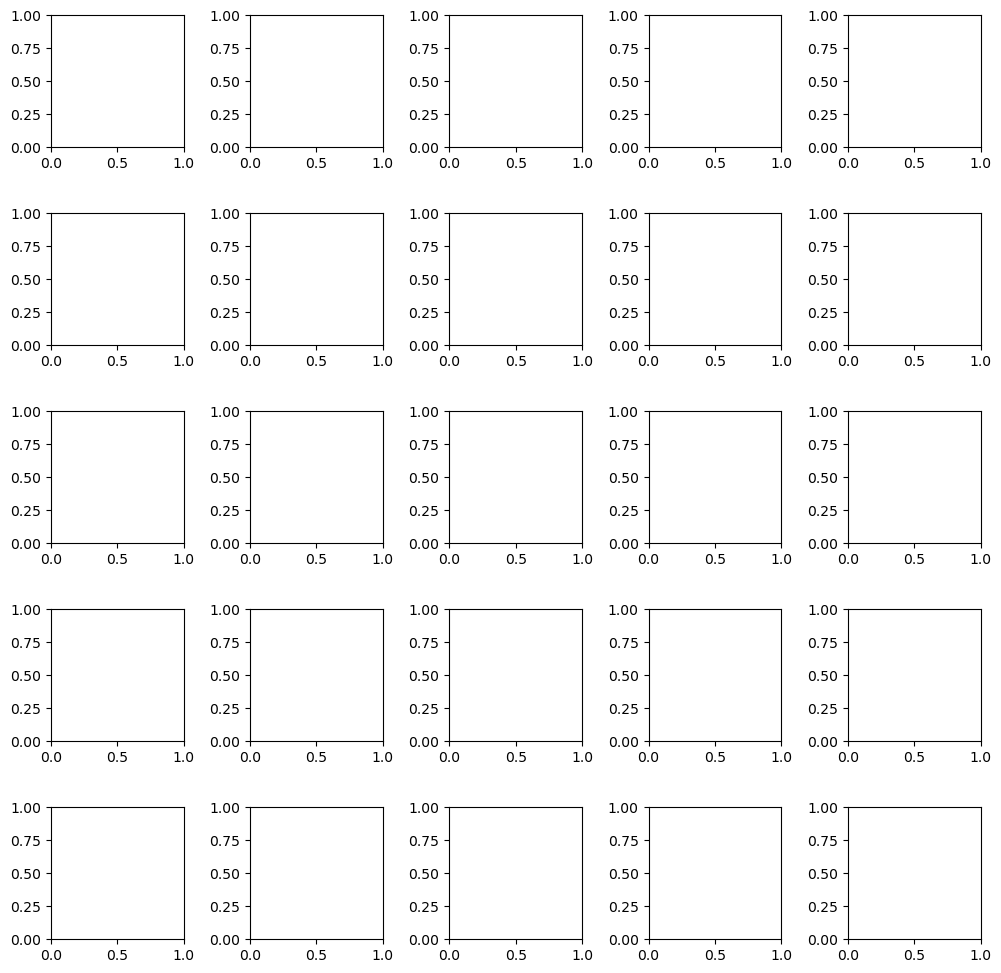

In [27]:
# Linear model & 이전데이터 추가 & diff_lat 예측 & wind_y만 사용

f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['wind_y']]
    train_y = train[0][['diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_y']] 
        trina_yi = train[j][['diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        trina_xi = only_train_dataset[k][['wind_y']] 
        trina_yi = only_train_dataset[k][['diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
        
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_y']]
    test_X = test_X[1:]
    test_y = test[['diff_lat']]
    test_y = test_y[1:].to_numpy()

    # 선형모델 생성
    linear = tf.keras.Sequential([
    Dense(units = 1, input_dim = 1)
    ])
    
    linear.summary()
    linear.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    linear.fit(train_X, train_y, epochs = 30, batch_size = 16)

    # Predict
    y_pred = linear.predict(test_X)

    # 실제 위치
#     lon = dataset[i]['obs_x1_lat']
#     lon = np.array(lon)
    lat = dataset[i]['obs_x1_lat']
    lat = np.array(lat)
    
    # 예측값 
#     first_lon = lon[0]
    first_lat = lat[0]
#     lon_pred = np.zeros((y_pred.shape[0]+1,))
    lat_pred = np.zeros((y_pred.shape[0]+1,))
#     lon_pred[0] = first_lon 
    lat_pred[0] = first_lat
    
    for t in range(1, lat_pred.shape[0]):
#         lon_pred[t] = lon_pred[t-1] + y_pred[t-1][0]
        lat_pred[t] = lat_pred[t-1] + y_pred[t-1][0]        
    
    # evaluation 
#     y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
#     pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(lat, lat_pred))
    MAE_list.append(drift_mae(lat, lat_pred))
    
    #NCLS
#     print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
#     NCLS_list.append(NCLS_score(y, pred))

In [28]:
linear_mae_sum = 0
for i in range(len(dataset)):
    print('---------------- ',i+1,'model ----------------')
    linear_mae_sum += MAE_list[i]
    print(i+1,'model의 MAE : ',MAE_list[i])
    print('---------------------------------------------')
    print(' ')

# 라이브러리 Mae    
print ('평균 Mae : ', linear_mae_sum/len(dataset) )

----------------  1 model ----------------
1 model의 MAE :  0.10129630852015155
---------------------------------------------
 
----------------  2 model ----------------
2 model의 MAE :  0.10474043083512719
---------------------------------------------
 
----------------  3 model ----------------
3 model의 MAE :  0.30706609861741757
---------------------------------------------
 
----------------  4 model ----------------
4 model의 MAE :  0.04605268807046029
---------------------------------------------
 
----------------  5 model ----------------
5 model의 MAE :  0.11151436320853682
---------------------------------------------
 
----------------  6 model ----------------
6 model의 MAE :  0.15363774945764014
---------------------------------------------
 
----------------  7 model ----------------
7 model의 MAE :  0.8094612574762644
---------------------------------------------
 
----------------  8 model ----------------
8 model의 MAE :  0.1313844245326754
----------------------------------

--------------------- Model  0  ----------------------
Model: "sequential_171"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_171 (Dense)           (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 750us/step - loss: 6.9086e-04 - mae: 0.0197
Epoch 2/30
185/185 [==============================] - 0s 835us/step - loss: 1.0196e-04 - mae: 0.0078
Epoch 3/30
185/185 [==============================] - 0s 899us/step - loss: 8.0989e-05 - mae: 0.0069
Epoch 4/30
185/185 [==============================] - 0s 973us/step - loss: 8.1006e-05 - mae: 0.0069
Epoch 5/30
185/185 [==============================] - 0s 997us/step - loss: 8.0476e-05 - mae: 0.0069
Epoch 6/30
185/185 [======

185/185 [==============================] - 0s 1ms/step - loss: 2.1487e-04 - mae: 0.0116
Epoch 13/30
185/185 [==============================] - 0s 1ms/step - loss: 1.2904e-04 - mae: 0.0089
Epoch 14/30
185/185 [==============================] - 0s 1ms/step - loss: 9.4838e-05 - mae: 0.0075
Epoch 15/30
185/185 [==============================] - 0s 1ms/step - loss: 8.2984e-05 - mae: 0.0070
Epoch 16/30
185/185 [==============================] - 0s 1ms/step - loss: 7.9150e-05 - mae: 0.0069
Epoch 17/30
185/185 [==============================] - 0s 1ms/step - loss: 7.8339e-05 - mae: 0.0068
Epoch 18/30
185/185 [==============================] - 0s 1ms/step - loss: 7.7878e-05 - mae: 0.0068
Epoch 19/30
185/185 [==============================] - 0s 1ms/step - loss: 7.7800e-05 - mae: 0.0068
Epoch 20/30
185/185 [==============================] - 0s 1ms/step - loss: 7.7957e-05 - mae: 0.0068
Epoch 21/30
185/185 [==============================] - 0s 1ms/step - loss: 7.7861e-05 - mae: 0.0068
Epoch 22/30


185/185 [==============================] - 0s 1ms/step - loss: 8.0637e-05 - mae: 0.0069
Epoch 29/30
185/185 [==============================] - 0s 1ms/step - loss: 8.0674e-05 - mae: 0.0069
Epoch 30/30
3/3 [==============================] - 0s 2ms/step
Model 8  MAE :  0.09066536803189162
--------------------- Model  9  ----------------------
Model: "sequential_180"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_180 (Dense)           (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 1s 1ms/step - loss: 0.0690 - mae: 0.2056
Epoch 2/30
185/185 [==============================] - 0s 889us/step - loss: 0.0497 - mae: 0.1737
Epoch 3/30
185/185 [==============================] 

_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 1s 777us/step - loss: 0.0447 - mae: 0.1651
Epoch 2/30
185/185 [==============================] - 0s 864us/step - loss: 0.0300 - mae: 0.1347
Epoch 3/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0195 - mae: 0.1086
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0122 - mae: 0.0856
Epoch 5/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0071 - mae: 0.0657
Epoch 6/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0040 - mae: 0.0489
Epoch 7/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0351
Epoch 8/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0010 - mae: 0.0247
Epoch 9/30
185/185 [==============================] - 0s 1ms/step - loss: 4.8044e-04 - mae: 0.0172
Epoch 10/30
185/185 [==============================] - 0s 1ms/step - lo

185/185 [==============================] - 0s 1ms/step - loss: 8.4120e-05 - mae: 0.0071
Epoch 18/30
185/185 [==============================] - 0s 1ms/step - loss: 8.3983e-05 - mae: 0.0071
Epoch 19/30
185/185 [==============================] - 0s 1ms/step - loss: 8.4151e-05 - mae: 0.0071
Epoch 20/30
185/185 [==============================] - 0s 1ms/step - loss: 8.3762e-05 - mae: 0.0071
Epoch 21/30
185/185 [==============================] - 0s 1ms/step - loss: 8.4751e-05 - mae: 0.0071
Epoch 22/30
185/185 [==============================] - 0s 1ms/step - loss: 8.4265e-05 - mae: 0.0071
Epoch 23/30
185/185 [==============================] - 0s 1ms/step - loss: 8.4729e-05 - mae: 0.0071
Epoch 24/30
185/185 [==============================] - 0s 1ms/step - loss: 8.3782e-05 - mae: 0.0071
Epoch 25/30
185/185 [==============================] - 0s 1ms/step - loss: 8.4181e-05 - mae: 0.0071
Epoch 26/30
185/185 [==============================] - 0s 1ms/step - loss: 8.3995e-05 - mae: 0.0071
Epoch 27/30


185/185 [==============================] - 0s 1ms/step - loss: 8.3111e-05 - mae: 0.0070
Epoch 27/30
185/185 [==============================] - 0s 1ms/step - loss: 8.3010e-05 - mae: 0.0070
Epoch 28/30
185/185 [==============================] - 0s 1ms/step - loss: 8.3002e-05 - mae: 0.0070
Epoch 29/30
185/185 [==============================] - 0s 1ms/step - loss: 8.3027e-05 - mae: 0.0070
Epoch 30/30
3/3 [==============================] - 0s 2ms/step
Model 17  MAE :  0.16801760694358403
--------------------- Model  18  ----------------------
Model: "sequential_189"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_189 (Dense)           (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [======================

                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0045 - mae: 0.0518
Epoch 2/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0014 - mae: 0.0287
Epoch 3/30
185/185 [==============================] - 0s 1ms/step - loss: 3.4133e-04 - mae: 0.0142
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1770e-04 - mae: 0.0084
Epoch 5/30
185/185 [==============================] - 0s 1ms/step - loss: 8.5422e-05 - mae: 0.0071
Epoch 6/30
185/185 [==============================] - 0s 1ms/step - loss: 8.3338e-05 - mae: 0.0070
Epoch 7/30
185/185 [==============================] - 0s 1ms/step - loss: 8.3183e-05 - mae: 0.0070
Epoch 8/30
185/185 [==============================] - 0s 1ms/step - loss: 8.3309e-05 - mae: 0.0070
Epoch 9/30
185/185 [====

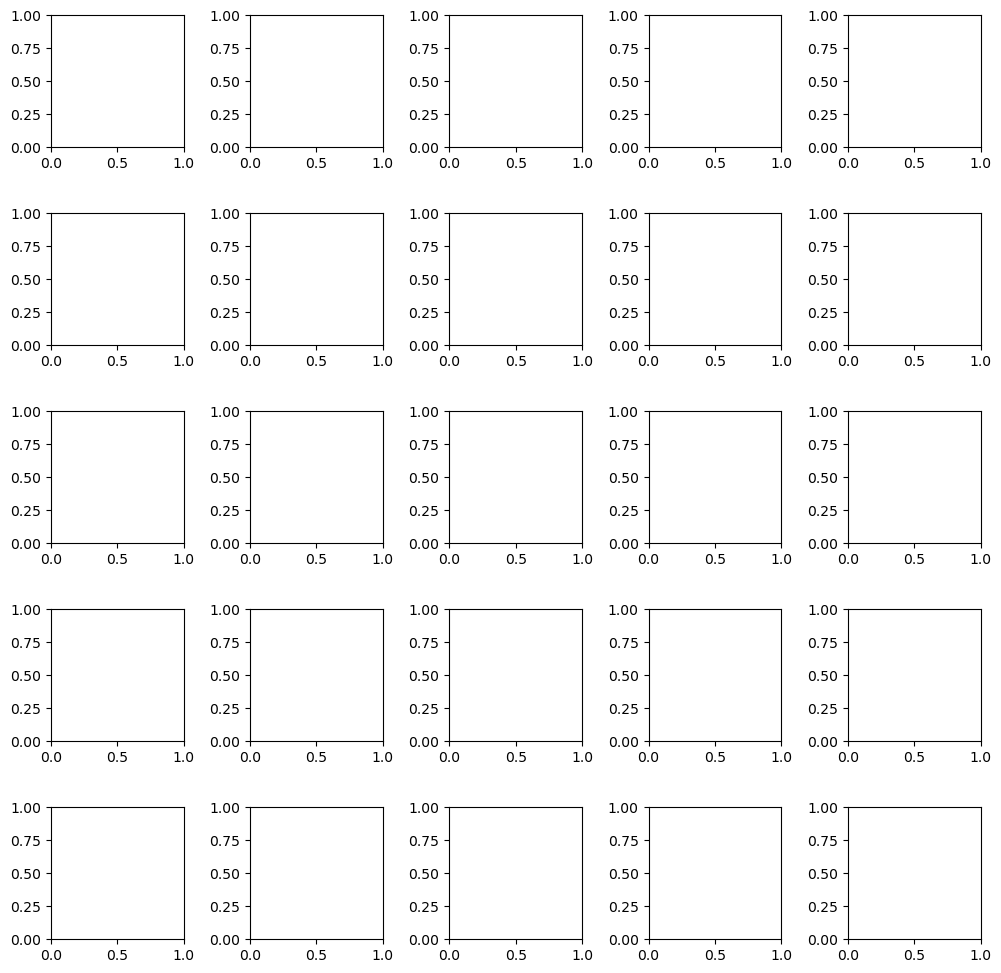

In [29]:
# Linear model & 이전데이터 추가 & diff_lat 예측 & 'water_velocity_y'만 사용

f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['water_velocity_y']]
    train_y = train[0][['diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['water_velocity_y']] 
        trina_yi = train[j][['diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        trina_xi = only_train_dataset[k][['water_velocity_y']] 
        trina_yi = only_train_dataset[k][['diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
        
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['water_velocity_y']]
    test_X = test_X[1:]
    test_y = test[['diff_lat']]
    test_y = test_y[1:].to_numpy()

    # 선형모델 생성
    linear = tf.keras.Sequential([
    Dense(units = 1, input_dim = 1)
    ])
    
    linear.summary()
    linear.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    linear.fit(train_X, train_y, epochs = 30, batch_size = 16)

    # Predict
    y_pred = linear.predict(test_X)

    # 실제 위치
#     lon = dataset[i]['obs_x1_lat']
#     lon = np.array(lon)
    lat = dataset[i]['obs_x1_lat']
    lat = np.array(lat)
    
    # 예측값 
#     first_lon = lon[0]
    first_lat = lat[0]
#     lon_pred = np.zeros((y_pred.shape[0]+1,))
    lat_pred = np.zeros((y_pred.shape[0]+1,))
#     lon_pred[0] = first_lon 
    lat_pred[0] = first_lat
    
    for t in range(1, lat_pred.shape[0]):
#         lon_pred[t] = lon_pred[t-1] + y_pred[t-1][0]
        lat_pred[t] = lat_pred[t-1] + y_pred[t-1][0]        
    
    # evaluation 
#     y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
#     pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(lat, lat_pred))
    MAE_list.append(drift_mae(lat, lat_pred))
    
    #NCLS
#     print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
#     NCLS_list.append(NCLS_score(y, pred))

In [30]:
linear_mae_sum = 0
for i in range(len(dataset)):
    print('---------------- ',i+1,'model ----------------')
    linear_mae_sum += MAE_list[i]
    print(i+1,'model의 MAE : ',MAE_list[i])
    print('---------------------------------------------')
    print(' ')

# 라이브러리 Mae    
print ('평균 Mae : ', linear_mae_sum/len(dataset) )

----------------  1 model ----------------
1 model의 MAE :  0.093061132913491
---------------------------------------------
 
----------------  2 model ----------------
2 model의 MAE :  0.2806863774185747
---------------------------------------------
 
----------------  3 model ----------------
3 model의 MAE :  0.4077765245548171
---------------------------------------------
 
----------------  4 model ----------------
4 model의 MAE :  0.10264168855053643
---------------------------------------------
 
----------------  5 model ----------------
5 model의 MAE :  0.19025813913132888
---------------------------------------------
 
----------------  6 model ----------------
6 model의 MAE :  0.10677775014645352
---------------------------------------------
 
----------------  7 model ----------------
7 model의 MAE :  0.6321919283315479
---------------------------------------------
 
----------------  8 model ----------------
8 model의 MAE :  0.1698450249813787
--------------------------------------

--------------------- Model  0  ----------------------
Model: "sequential_193"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_193 (Dense)           (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 894us/step - loss: 3.1115 - mae: 1.4324
Epoch 2/30
185/185 [==============================] - 0s 897us/step - loss: 1.1420 - mae: 0.8597
Epoch 3/30
185/185 [==============================] - 0s 1ms/step - loss: 0.3562 - mae: 0.4737
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 0.1065 - mae: 0.2595
Epoch 5/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0428 - mae: 0.1642
Epoch 6/30
185/185 [==============================] 

Epoch 13/30
185/185 [==============================] - 0s 1ms/step - loss: 6.0965e-05 - mae: 0.0060
Epoch 14/30
185/185 [==============================] - 0s 1ms/step - loss: 6.1105e-05 - mae: 0.0060
Epoch 15/30
185/185 [==============================] - 0s 1ms/step - loss: 6.1001e-05 - mae: 0.0060
Epoch 16/30
185/185 [==============================] - 0s 1ms/step - loss: 6.1370e-05 - mae: 0.0060
Epoch 17/30
185/185 [==============================] - 0s 1ms/step - loss: 6.1231e-05 - mae: 0.0060
Epoch 18/30
185/185 [==============================] - 0s 1ms/step - loss: 6.1110e-05 - mae: 0.0060
Epoch 19/30
185/185 [==============================] - 0s 1ms/step - loss: 6.1274e-05 - mae: 0.0060
Epoch 20/30
185/185 [==============================] - 0s 1ms/step - loss: 6.1119e-05 - mae: 0.0060
Epoch 21/30
185/185 [==============================] - 0s 1ms/step - loss: 6.1555e-05 - mae: 0.0060
Epoch 22/30
185/185 [==============================] - 0s 1ms/step - loss: 6.1464e-05 - mae: 0.0060


3/3 [==============================] - 0s 1ms/step
Model 8  MAE :  0.061544393782602666
--------------------- Model  9  ----------------------
Model: "sequential_202"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_202 (Dense)           (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 993us/step - loss: 8.6172 - mae: 2.4068
Epoch 2/30
185/185 [==============================] - 0s 908us/step - loss: 4.6604 - mae: 1.7705
Epoch 3/30
185/185 [==============================] - 0s 1ms/step - loss: 2.3042 - mae: 1.2434
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 1.0262 - mae: 0.8242
Epoch 5/30
185/185 [==============================] - 0s 1m

185/185 [==============================] - 0s 1ms/step - loss: 6.3521e-05 - mae: 0.0061
Epoch 14/30
185/185 [==============================] - 0s 1ms/step - loss: 6.4202e-05 - mae: 0.0061
Epoch 15/30
185/185 [==============================] - 0s 1ms/step - loss: 6.3672e-05 - mae: 0.0061
Epoch 16/30
185/185 [==============================] - 0s 1ms/step - loss: 6.4062e-05 - mae: 0.0061
Epoch 17/30
185/185 [==============================] - 0s 1ms/step - loss: 6.4419e-05 - mae: 0.0062
Epoch 18/30
185/185 [==============================] - 0s 1ms/step - loss: 6.4313e-05 - mae: 0.0062
Epoch 19/30
185/185 [==============================] - 0s 1ms/step - loss: 6.4655e-05 - mae: 0.0062
Epoch 20/30
185/185 [==============================] - 0s 1ms/step - loss: 6.4405e-05 - mae: 0.0062
Epoch 21/30
185/185 [==============================] - 0s 1ms/step - loss: 6.4938e-05 - mae: 0.0062
Epoch 22/30
185/185 [==============================] - 0s 1ms/step - loss: 6.6565e-05 - mae: 0.0063
Epoch 23/30


Epoch 23/30
185/185 [==============================] - 0s 1ms/step - loss: 1.2816e-04 - mae: 0.0090
Epoch 24/30
185/185 [==============================] - 0s 1ms/step - loss: 9.4687e-05 - mae: 0.0077
Epoch 25/30
185/185 [==============================] - 0s 1ms/step - loss: 7.7180e-05 - mae: 0.0069
Epoch 26/30
185/185 [==============================] - 0s 1ms/step - loss: 6.8868e-05 - mae: 0.0065
Epoch 27/30
185/185 [==============================] - 0s 1ms/step - loss: 6.5175e-05 - mae: 0.0062
Epoch 28/30
185/185 [==============================] - 0s 1ms/step - loss: 6.3899e-05 - mae: 0.0062
Epoch 29/30
185/185 [==============================] - 0s 1ms/step - loss: 6.3471e-05 - mae: 0.0061
Epoch 30/30
3/3 [==============================] - 0s 2ms/step
Model 15  MAE :  0.023304045781118
--------------------- Model  16  ----------------------
Model: "sequential_209"
_________________________________________________________________
 Layer (type)                Output Shape              P

 Layer (type)                Output Shape              Param #   
 dense_211 (Dense)           (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 989us/step - loss: 29.3622 - mae: 4.4714
Epoch 2/30
185/185 [==============================] - 0s 987us/step - loss: 21.1922 - mae: 3.8023
Epoch 3/30
185/185 [==============================] - 0s 1ms/step - loss: 14.8444 - mae: 3.1809
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 10.0901 - mae: 2.6197
Epoch 5/30
185/185 [==============================] - 0s 1ms/step - loss: 6.6138 - mae: 2.1198
Epoch 6/30
185/185 [==============================] - 0s 1ms/step - loss: 4.1556 - mae: 1.6803
Epoch 7/30
185/185 [==============================] - 0s 1ms/step - loss: 2.4858 - mae: 1.3006
Epo

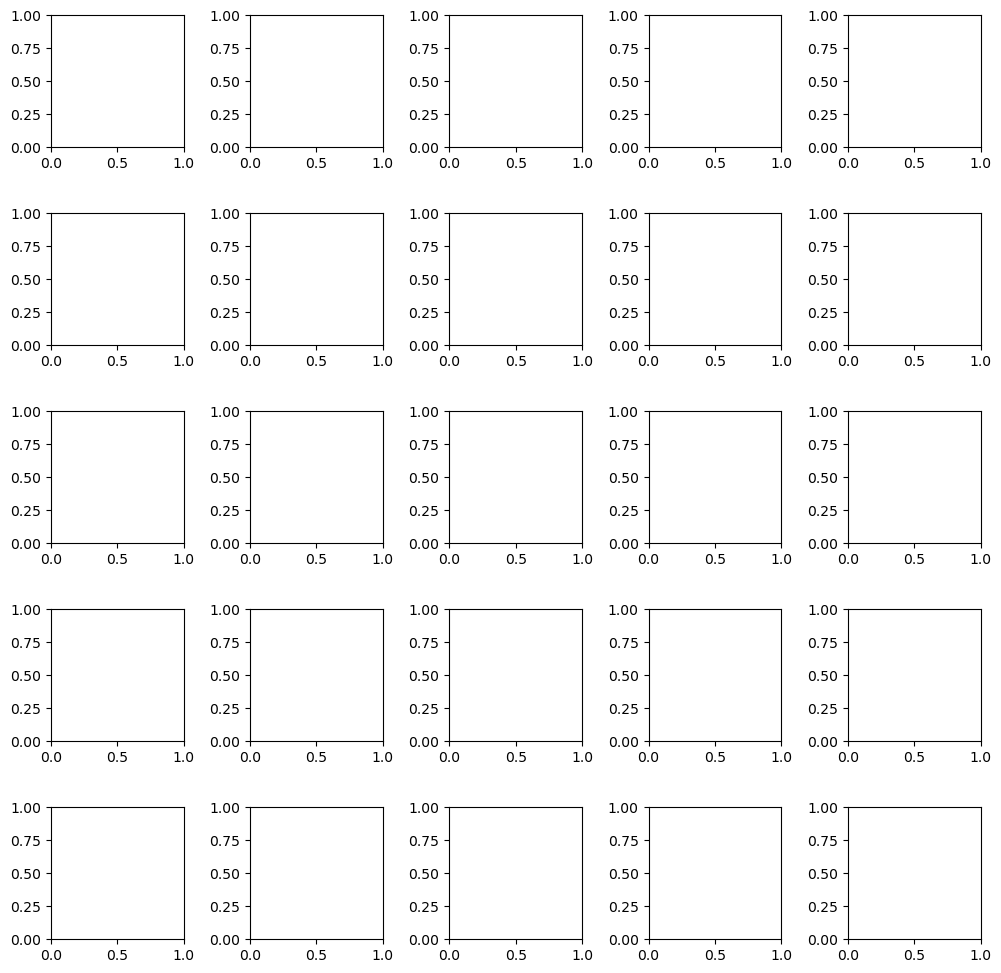

In [31]:
# Linear model & 이전데이터 추가 & diff_lat 예측 & wind_y,'water_velocity_y' 사용

f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['wind_y', 'water_velocity_y']]
    train_y = train[0][['diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_y','water_velocity_y']] 
        trina_yi = train[j][['diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        trina_xi = only_train_dataset[k][['wind_y','water_velocity_y']] 
        trina_yi = only_train_dataset[k][['diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
        
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_y','water_velocity_y']]
    test_X = test_X[1:]
    test_y = test[['diff_lat']]
    test_y = test_y[1:].to_numpy()

    # 선형모델 생성
    linear = tf.keras.Sequential([
    Dense(units = 1, input_dim = 2)
    ])
    
    linear.summary()
    linear.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    linear.fit(train_X, train_y, epochs = 30, batch_size = 16)

    # Predict
    y_pred = linear.predict(test_X)

    # 실제 위치
#     lon = dataset[i]['obs_x1_lat']
#     lon = np.array(lon)
    lat = dataset[i]['obs_x1_lat']
    lat = np.array(lat)
    
    # 예측값 
#     first_lon = lon[0]
    first_lat = lat[0]
#     lon_pred = np.zeros((y_pred.shape[0]+1,))
    lat_pred = np.zeros((y_pred.shape[0]+1,))
#     lon_pred[0] = first_lon 
    lat_pred[0] = first_lat
    
    for t in range(1, lat_pred.shape[0]):
#         lon_pred[t] = lon_pred[t-1] + y_pred[t-1][0]
        lat_pred[t] = lat_pred[t-1] + y_pred[t-1][0]        
    
    # evaluation 
#     y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
#     pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(lat, lat_pred))
    MAE_list.append(drift_mae(lat, lat_pred))
    
    #NCLS
#     print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
#     NCLS_list.append(NCLS_score(y, pred))

In [32]:
linear_mae_sum = 0
for i in range(len(dataset)):
    print('---------------- ',i+1,'model ----------------')
    linear_mae_sum += MAE_list[i]
    print(i+1,'model의 MAE : ',MAE_list[i])
    print('---------------------------------------------')
    print(' ')

# 라이브러리 Mae    
print ('평균 Mae : ', linear_mae_sum/len(dataset) )

----------------  1 model ----------------
1 model의 MAE :  0.11459330612661518
---------------------------------------------
 
----------------  2 model ----------------
2 model의 MAE :  0.23573694405760076
---------------------------------------------
 
----------------  3 model ----------------
3 model의 MAE :  0.2954654430475545
---------------------------------------------
 
----------------  4 model ----------------
4 model의 MAE :  0.1700619350272727
---------------------------------------------
 
----------------  5 model ----------------
5 model의 MAE :  0.16319630918688588
---------------------------------------------
 
----------------  6 model ----------------
6 model의 MAE :  0.1853642077260096
---------------------------------------------
 
----------------  7 model ----------------
7 model의 MAE :  0.7146159210258518
---------------------------------------------
 
----------------  8 model ----------------
8 model의 MAE :  0.05615167278925496
------------------------------------

In [35]:
# Linear model & 이전데이터 추가 & diff_lat 예측 & 'wind_x', 'water_velocity_x','wind_y', 'water_velocity_y'사용

MAE_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['wind_x', 'water_velocity_x','wind_y', 'water_velocity_y']]
    train_y = train[0][['diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'water_velocity_x', 'wind_y','water_velocity_y']] 
        trina_yi = train[j][['diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        trina_xi = only_train_dataset[k][['wind_x', 'water_velocity_x', 'wind_y','water_velocity_y']] 
        trina_yi = only_train_dataset[k][['diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
        
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'water_velocity_x','wind_y','water_velocity_y']]
    test_X = test_X[1:]
    test_y = test[['diff_lat']]
    test_y = test_y[1:].to_numpy()

    # 선형모델 생성
    linear = tf.keras.Sequential([
    Dense(units = 1, input_dim = 4)
    ])
    
    linear.summary()
    linear.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    linear.fit(train_X, train_y, epochs = 30, batch_size = 16)

    # Predict
    y_pred = linear.predict(test_X)

    # 실제 위치
#     lon = dataset[i]['obs_x1_lat']
#     lon = np.array(lon)
    lat = dataset[i]['obs_x1_lat']
    lat = np.array(lat)
    
    # 예측값 
#     first_lon = lon[0]
    first_lat = lat[0]
#     lon_pred = np.zeros((y_pred.shape[0]+1,))
    lat_pred = np.zeros((y_pred.shape[0]+1,))
#     lon_pred[0] = first_lon 
    lat_pred[0] = first_lat
    
    for t in range(1, lat_pred.shape[0]):
#         lon_pred[t] = lon_pred[t-1] + y_pred[t-1][0]
        lat_pred[t] = lat_pred[t-1] + y_pred[t-1][0]        
    
    # evaluation 
#     y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
#     pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(lat, lat_pred))
    MAE_list.append(drift_mae(lat, lat_pred))
    
    #NCLS
#     print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
#     NCLS_list.append(NCLS_score(y, pred))

--------------------- Model  0  ----------------------
Model: "sequential_215"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_215 (Dense)           (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 1s 1000us/step - loss: 23.8986 - mae: 4.0242
Epoch 2/30
185/185 [==============================] - 0s 787us/step - loss: 15.8138 - mae: 3.2697
Epoch 3/30
185/185 [==============================] - 0s 776us/step - loss: 10.0439 - mae: 2.5987
Epoch 4/30
185/185 [==============================] - 0s 815us/step - loss: 6.1373 - mae: 2.0269
Epoch 5/30
185/185 [==============================] - 0s 901us/step - loss: 3.5706 - mae: 1.5370
Epoch 6/30
185/185 [======================

185/185 [==============================] - 0s 932us/step - loss: 0.0783 - mae: 0.2280
Epoch 12/30
185/185 [==============================] - 0s 921us/step - loss: 0.0413 - mae: 0.1647
Epoch 13/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0245 - mae: 0.1254
Epoch 14/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0162 - mae: 0.1010
Epoch 15/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0116 - mae: 0.0846
Epoch 16/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0085 - mae: 0.0721
Epoch 17/30
185/185 [==============================] - 0s 978us/step - loss: 0.0062 - mae: 0.0613
Epoch 18/30
185/185 [==============================] - 0s 968us/step - loss: 0.0044 - mae: 0.0517
Epoch 19/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0031 - mae: 0.0431
Epoch 20/30
185/185 [==============================] - 0s 955us/step - loss: 0.0021 - mae: 0.0355
Epoch 21/30
185/185 [=====================

Epoch 28/30
185/185 [==============================] - 0s 965us/step - loss: 6.5053e-05 - mae: 0.0063
Epoch 29/30
185/185 [==============================] - 0s 968us/step - loss: 6.1589e-05 - mae: 0.0060
Epoch 30/30
3/3 [==============================] - 0s 2ms/step
Model 8  MAE :  0.06734908523739759
--------------------- Model  9  ----------------------
Model: "sequential_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_224 (Dense)           (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 1s 999us/step - loss: 0.5182 - mae: 0.5749
Epoch 2/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0505 - mae: 0.1719
Epoch 3/30
185/185 [================

Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 715us/step - loss: 26.4023 - mae: 4.2068
Epoch 2/30
185/185 [==============================] - 0s 968us/step - loss: 17.4805 - mae: 3.4178
Epoch 3/30
185/185 [==============================] - 0s 1ms/step - loss: 11.1322 - mae: 2.7195
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 6.7841 - mae: 2.1142
Epoch 5/30
185/185 [==============================] - 0s 1ms/step - loss: 3.9352 - mae: 1.6014
Epoch 6/30
185/185 [==============================] - 0s 1ms/step - loss: 2.1602 - mae: 1.1764
Epoch 7/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1428 - mae: 0.8521
Epoch 8/30
185/185 [==============================] - 0s 1ms/step - loss: 0.5891 - mae: 0.6117
Epoch 9/30
185/185 [==============================] - 0s 1ms/step - loss: 0.2992 - mae: 0.4374
Epoch 10/30
185/185 [=======

185/185 [==============================] - 0s 1ms/step - loss: 0.0129 - mae: 0.0888
Epoch 11/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0079 - mae: 0.0693
Epoch 12/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0054 - mae: 0.0567
Epoch 13/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0037 - mae: 0.0472
Epoch 14/30
185/185 [==============================] - 0s 986us/step - loss: 0.0025 - mae: 0.0390
Epoch 15/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0017 - mae: 0.0319
Epoch 16/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0011 - mae: 0.0256
Epoch 17/30
185/185 [==============================] - 0s 1ms/step - loss: 6.7426e-04 - mae: 0.0203
Epoch 18/30
185/185 [==============================] - 0s 1ms/step - loss: 4.1017e-04 - mae: 0.0158
Epoch 19/30
185/185 [==============================] - 0s 1ms/step - loss: 2.5037e-04 - mae: 0.0124
Epoch 20/30
185/185 [=================

185/185 [==============================] - 0s 1ms/step - loss: 1.0202e-04 - mae: 0.0076
Epoch 29/30
185/185 [==============================] - 0s 1ms/step - loss: 7.9755e-05 - mae: 0.0067
Epoch 30/30
3/3 [==============================] - 0s 2ms/step
Model 17  MAE :  0.2497068231773093
--------------------- Model  18  ----------------------
Model: "sequential_233"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_233 (Dense)           (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 917us/step - loss: 0.1740 - mae: 0.3156
Epoch 2/30
185/185 [==============================] - 0s 872us/step - loss: 0.0263 - mae: 0.1242
Epoch 3/30
185/185 [=============================

Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 994us/step - loss: 0.9554 - mae: 0.7472
Epoch 2/30
185/185 [==============================] - 0s 844us/step - loss: 0.0676 - mae: 0.1930
Epoch 3/30
185/185 [==============================] - 0s 961us/step - loss: 0.0076 - mae: 0.0684
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0038 - mae: 0.0488
Epoch 5/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0358
Epoch 6/30
185/185 [==============================] - 0s 1ms/step - loss: 9.8968e-04 - mae: 0.0254
Epoch 7/30
185/185 [==============================] - 0s 1ms/step - loss: 4.5701e-04 - mae: 0.0174
Epoch 8/30
185/185 [==============================] - 0s 1ms/step - loss: 2.1173e-04 - mae: 0.0119
Epoch 9/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1226e-04 - mae: 0.0086
Epoch 10/30
185/185 [============

In [36]:
linear_mae_sum = 0
for i in range(len(dataset)):
    print('---------------- ',i+1,'model ----------------')
    linear_mae_sum += MAE_list[i]
    print(i+1,'model의 MAE : ',MAE_list[i])
    print('---------------------------------------------')
    print(' ')

# 라이브러리 Mae    
print ('평균 Mae : ', linear_mae_sum/len(dataset) )

----------------  1 model ----------------
1 model의 MAE :  0.10301515363739089
---------------------------------------------
 
----------------  2 model ----------------
2 model의 MAE :  0.2395825223584741
---------------------------------------------
 
----------------  3 model ----------------
3 model의 MAE :  0.3417109488520674
---------------------------------------------
 
----------------  4 model ----------------
4 model의 MAE :  0.1437241535847365
---------------------------------------------
 
----------------  5 model ----------------
5 model의 MAE :  0.16872861928168773
---------------------------------------------
 
----------------  6 model ----------------
6 model의 MAE :  0.22387068883857264
---------------------------------------------
 
----------------  7 model ----------------
7 model의 MAE :  0.6929798877879692
---------------------------------------------
 
----------------  8 model ----------------
8 model의 MAE :  0.042344441440644275
-----------------------------------

In [37]:
# Linear model & 이전데이터 추가 & diff_lon 예측 & 'wind_x', 'water_velocity_x','wind_y', 'water_velocity_y'사용

MAE_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['wind_x', 'water_velocity_x','wind_y', 'water_velocity_y']]
    train_y = train[0][['diff_lon']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'water_velocity_x','wind_y','water_velocity_y']] 
        trina_yi = train[j][['diff_lon']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        trina_xi = only_train_dataset[k][['wind_x', 'water_velocity_x','wind_y','water_velocity_y']] 
        trina_yi = only_train_dataset[k][['diff_lon']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
        
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'water_velocity_x','wind_y','water_velocity_y']]
    test_X = test_X[1:]
    test_y = test[['diff_lon']]
    test_y = test_y[1:].to_numpy()

    # 선형모델 생성
    linear = tf.keras.Sequential([
    Dense(units = 1, input_dim = 4)
    ])
    
    linear.summary()
    linear.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    linear.fit(train_X, train_y, epochs = 30, batch_size = 16)

    # Predict
    y_pred = linear.predict(test_X)

    # 실제 위치
    lon = dataset[i]['obs_x1_lon']
    lon = np.array(lon)
#     lat = dataset[i]['obs_x1_lat']
#     lat = np.array(lat)
    
    # 예측값 
    first_lon = lon[0]
#     first_lat = lat[0]
    lon_pred = np.zeros((y_pred.shape[0]+1,))
#     lat_pred = np.zeros((y_pred.shape[0]+1,))
    lon_pred[0] = first_lon 
#     lat_pred[0] = first_lat
    
    for t in range(1, lon_pred.shape[0]):
        lon_pred[t] = lon_pred[t-1] + y_pred[t-1][0]
#         lat_pred[t] = lat_pred[t-1] + y_pred[t-1][0]        
    
    # evaluation 
#     y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
#     pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(lat, lat_pred))
    MAE_list.append(drift_mae(lat, lat_pred))
    
    #NCLS
#     print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
#     NCLS_list.append(NCLS_score(y, pred))

--------------------- Model  0  ----------------------
Model: "sequential_237"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_237 (Dense)           (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 760us/step - loss: 8.4379 - mae: 2.3668
Epoch 2/30
185/185 [==============================] - 0s 886us/step - loss: 4.1233 - mae: 1.6639
Epoch 3/30
185/185 [==============================] - 0s 885us/step - loss: 1.9987 - mae: 1.1547
Epoch 4/30
185/185 [==============================] - 0s 905us/step - loss: 0.9201 - mae: 0.7814
Epoch 5/30
185/185 [==============================] - 0s 901us/step - loss: 0.3914 - mae: 0.5069
Epoch 6/30
185/185 [==========================

185/185 [==============================] - 0s 1ms/step - loss: 6.0126e-04 - mae: 0.0199
Epoch 15/30
185/185 [==============================] - 0s 1ms/step - loss: 2.3557e-04 - mae: 0.0123
Epoch 16/30
185/185 [==============================] - 0s 1ms/step - loss: 1.3855e-04 - mae: 0.0093
Epoch 17/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1142e-04 - mae: 0.0082
Epoch 18/30
185/185 [==============================] - 0s 1ms/step - loss: 1.0113e-04 - mae: 0.0077
Epoch 19/30
185/185 [==============================] - 0s 1ms/step - loss: 9.5003e-05 - mae: 0.0074
Epoch 20/30
185/185 [==============================] - 0s 1ms/step - loss: 9.0633e-05 - mae: 0.0072
Epoch 21/30
185/185 [==============================] - 0s 1ms/step - loss: 8.7647e-05 - mae: 0.0071
Epoch 22/30
185/185 [==============================] - 0s 1ms/step - loss: 8.5475e-05 - mae: 0.0070
Epoch 23/30
185/185 [==============================] - 0s 1ms/step - loss: 8.3928e-05 - mae: 0.0069
Epoch 24/30


Model: "sequential_246"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_246 (Dense)           (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 672us/step - loss: 12.6234 - mae: 2.9592
Epoch 2/30
185/185 [==============================] - 0s 878us/step - loss: 7.6658 - mae: 2.3041
Epoch 3/30
185/185 [==============================] - 0s 967us/step - loss: 4.4054 - mae: 1.7432
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 2.3577 - mae: 1.2751
Epoch 5/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1510 - mae: 0.8894
Epoch 6/30
185/185 [==============================] - 0s 1ms/step - loss: 0.5237 - mae: 0.5976
Epoch 7/3

185/185 [==============================] - 0s 1ms/step - loss: 0.0044 - mae: 0.0514
Epoch 16/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0028 - mae: 0.0409
Epoch 17/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0017 - mae: 0.0318
Epoch 18/30
185/185 [==============================] - 0s 1ms/step - loss: 9.8924e-04 - mae: 0.0245
Epoch 19/30
185/185 [==============================] - 0s 1ms/step - loss: 5.6880e-04 - mae: 0.0186
Epoch 20/30
185/185 [==============================] - 0s 1ms/step - loss: 3.2882e-04 - mae: 0.0141
Epoch 21/30
185/185 [==============================] - 0s 1ms/step - loss: 1.9919e-04 - mae: 0.0109
Epoch 22/30
185/185 [==============================] - 0s 1ms/step - loss: 1.3397e-04 - mae: 0.0089
Epoch 23/30
185/185 [==============================] - 0s 1ms/step - loss: 1.0306e-04 - mae: 0.0078
Epoch 24/30
185/185 [==============================] - 0s 1ms/step - loss: 8.9206e-05 - mae: 0.0072
Epoch 25/30
185/185 [===

185/185 [==============================] - 0s 1ms/step - loss: 1.0033e-04 - mae: 0.0074
Epoch 26/30
185/185 [==============================] - 0s 1ms/step - loss: 8.9583e-05 - mae: 0.0070
Epoch 27/30
185/185 [==============================] - 0s 990us/step - loss: 8.5145e-05 - mae: 0.0069
Epoch 28/30
185/185 [==============================] - 0s 961us/step - loss: 8.3396e-05 - mae: 0.0069
Epoch 29/30
185/185 [==============================] - 0s 977us/step - loss: 8.2797e-05 - mae: 0.0069
Epoch 30/30
3/3 [==============================] - 0s 1ms/step
Model 15  MAE :  0.11743030639389097
--------------------- Model  16  ----------------------
Model: "sequential_253"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_253 (Dense)           (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
__

 dense_255 (Dense)           (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 1s 887us/step - loss: 18.3356 - mae: 3.5038
Epoch 2/30
185/185 [==============================] - 0s 1ms/step - loss: 10.4098 - mae: 2.6539
Epoch 3/30
185/185 [==============================] - 0s 1ms/step - loss: 5.7012 - mae: 1.9806
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 3.1270 - mae: 1.4689
Epoch 5/30
185/185 [==============================] - 0s 1ms/step - loss: 1.6768 - mae: 1.0735
Epoch 6/30
185/185 [==============================] - 0s 1ms/step - loss: 0.8659 - mae: 0.7652
Epoch 7/30
185/185 [==============================] - 0s 1ms/step - loss: 0.4232 - mae: 0.5315
Epoch 8/30
185/185 [==============================] - 0s 1ms/step - loss:

In [38]:
linear_mae_sum = 0
for i in range(len(dataset)):
    print('---------------- ',i+1,'model ----------------')
    linear_mae_sum += MAE_list[i]
    print(i+1,'model의 MAE : ',MAE_list[i])
    print('---------------------------------------------')
    print(' ')

# 라이브러리 Mae    
print ('평균 Mae : ', linear_mae_sum/len(dataset) )

----------------  1 model ----------------
1 model의 MAE :  0.11743030639389097
---------------------------------------------
 
----------------  2 model ----------------
2 model의 MAE :  0.11743030639389097
---------------------------------------------
 
----------------  3 model ----------------
3 model의 MAE :  0.11743030639389097
---------------------------------------------
 
----------------  4 model ----------------
4 model의 MAE :  0.11743030639389097
---------------------------------------------
 
----------------  5 model ----------------
5 model의 MAE :  0.11743030639389097
---------------------------------------------
 
----------------  6 model ----------------
6 model의 MAE :  0.11743030639389097
---------------------------------------------
 
----------------  7 model ----------------
7 model의 MAE :  0.11743030639389097
---------------------------------------------
 
----------------  8 model ----------------
8 model의 MAE :  0.11743030639389097
--------------------------------

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:306: SettingWithCopyWarning: 
A value is trying to b

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: Futur

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:306: SettingWithCopyWarning: 
A value is trying to b

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

--------------------- Model  0  ----------------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7384\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

389/389 [==============================] - 1s 1ms/step - loss: 0.6851 - mae: 0.6335
Epoch 2/70
389/389 [==============================] - 0s 829us/step - loss: 0.2498 - mae: 0.3766
Epoch 3/70
389/389 [==============================] - 1s 2ms/step - loss: 0.0793 - mae: 0.2060
Epoch 4/70
389/389 [==============================] - 1s 1ms/step - loss: 0.0208 - mae: 0.1018
Epoch 5/70
389/389 [==============================] - 1s 2ms/step - loss: 0.0042 - mae: 0.0434
Epoch 6/70
389/389 [==============================] - 0s 1ms/step - loss: 6.2783e-04 - mae: 0.0158
Epoch 7/70
389/389 [==============================] - 0s 949us/step - loss: 7.3108e-05 - mae: 0.0055
Epoch 8/70
389/389 [==============================] - 0s 1ms/step - loss: 1.0968e-05 - mae: 0.0025
Epoch 9/70
389/389 [==============================] - 1s 2ms/step - loss: 5.7072e-06 - mae: 0.0018
Epoch 10/70
389/389 [==============================] - 0s 735us/step - loss: 5.3660e-06 - mae: 0.0018
Epoch 11/70
389/389 [=============

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

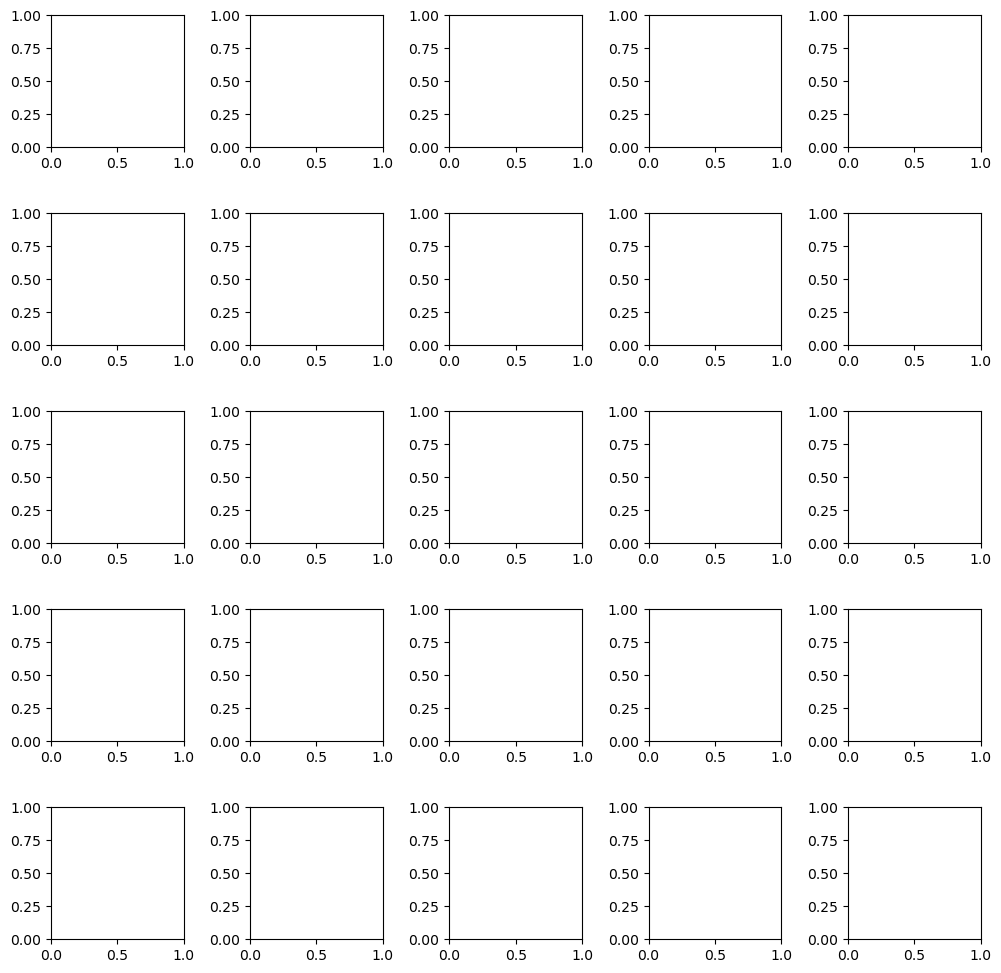

In [49]:
# Linear model & 데이터 추가

f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()
# 데이터 추가
data_augmenatation(dataset)

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
        
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    train_X, test_X = roburst_scaler(train_X, test_X)
    # 선형모델 생성
    linear = tf.keras.Sequential([
    Dense(units = 2, input_dim = 4)
    ])
    
    linear.summary()
    linear.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    linear.fit(train_X, train_y, epochs = 70, batch_size = 16)
    
    # model save
#     linear.save(str(i)+'linear_model.h5')

    # Predict
    y_pred = linear.predict(test_X)
    y_pred = y_pred[::2]
    test_X = test_X[::2]
    test_y = test_y[::2]
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    
    print('Model',str(i),' MAE : ', drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [ ]:
linear_mae_sum = 0
for i in range(len(dataset)):
    print('---------------- ',i+1,'model ----------------')
    linear_mae_sum += MAE_list[i]
    print(i+1,'model의 MAE : ',MAE_list[i])
    print('---------------------------------------------')
    print(' ')

# 라이브러리 Mae    
print ('평균 Mae : ', linear_mae_sum/len(dataset) )